# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки и анализа данных.
- навыки анализа и предварительной обработки данных
- визуализация данных
- анализ Временных Рядов

Проект включает в себя:
1. Предварительная обработка данных:
    - Ресемплирование данных
    - Обработка данных для моделей Машинного Обучения
2. Анализ данных:
    - Анализ Временных Рядов
3. Feature Engineering:
    - Извлечение дополнительных признаков для моделей Машинного Обучения
4. Исследование моделей машинного обучения

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [1]:
%%html
<style>
table {float:left}
</style>

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Анализ данных - тренды сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Модели машинного обучения для задач регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
# Метрики регрессии - оценка моделей
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
# Проверка моделей на вменяемость
from sklearn.dummy import DummyRegressor
# Для разделения данных на обучающий, тестовый набор данных. 
from sklearn.model_selection import train_test_split,GridSearchCV
# Кросс-валидация
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Настройка matplotlib

In [3]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [4]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [5]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [6]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

# Временные ряды

# Проект "Прогноз заказов такси на следующий час"

## Описание проекта 

Компания, оказывающая такси сервис, нуждается в системе прогноза количества заказов такси на следующий час, чтобы привлечь больше водителей в период пиково нагрузки.

## Описание данных

Предоставлены данные - исторические данные: заказы такси в аэропортах

## Детали задачи
Заказчику важны:
- Значение метрики RMSE на тестовой выборке должно быть не больше 48.





 |Столбец            |Описание          |Тип столбца
 |:---------------|:------------------------|:-------------|
 |num_orders    | Количество заказов такси|target  |

## Цель проекта
Построить модель, которая будет предсказывать количество заказов такси на следующий час.

## План работы
1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Ресемплирование](#resample)
    - [Финальная проверка данных](#dataCheck)
3. [Анализ данных](#dataAnalysis)
    - [Скользящее среднее](#movingAverage)
    - [Тренд](#trend)
    - [Сезонность](#seasonal)
4. [Feature Engineering](#featureEngineering)
5. [Исследование моделей машинного обучения](#MLmodelResearch)
6. [Результаты исследования моделей машинного обучения](#resultsRearchModel)
7. [Результаты работы](#results)

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленный файл. Сохраним в соотвествующую переменную.

In [7]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)
        
# Словарь с именем файла и ссылкой на него
urls = {
    'taxi': ('datasets/taxi.csv', '_____________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученный из файла датафрейм в соответствующую переменную
raw_taxi = pd.read_csv(urls['taxi'][0],sep=',', index_col=[0], parse_dates=[0])

Посмотрим на данные. Выведем первые 10 строк таблицы.

In [8]:
raw_taxi.head(10)

Заметим, что интервал между значениями ряда: **10 минут**

Проверим, в хронологическом ли порядке расположены даты и время с помощью атрибута индекса таблицы *is_monotonic*

In [9]:
if(raw_taxi.index.is_monotonic):
    print('Данные в хронологическом порядке')
else:
    print('Порядок не соблюдён')

Хорошо, данные в хронологическом порядке.

Посмотрим на общие данные, вызвав метод *info()*

In [10]:
raw_taxi.info()

Всего 26496 обьектов, 1 столбец с типом *int64*. Пропущенных значений нету. Нам предоставили данные с марта 2018 года по август 2018.

In [11]:
raw_taxi.describe()

Максимальное количество заказов в этот период - 119 заказов за 10 минут.

Построим график

Для начала напишем функцию для вывода графиков временного ряда

In [12]:
def timeSeriesPlot(df, title, xlabel, ylabel):
    sns.lineplot(data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

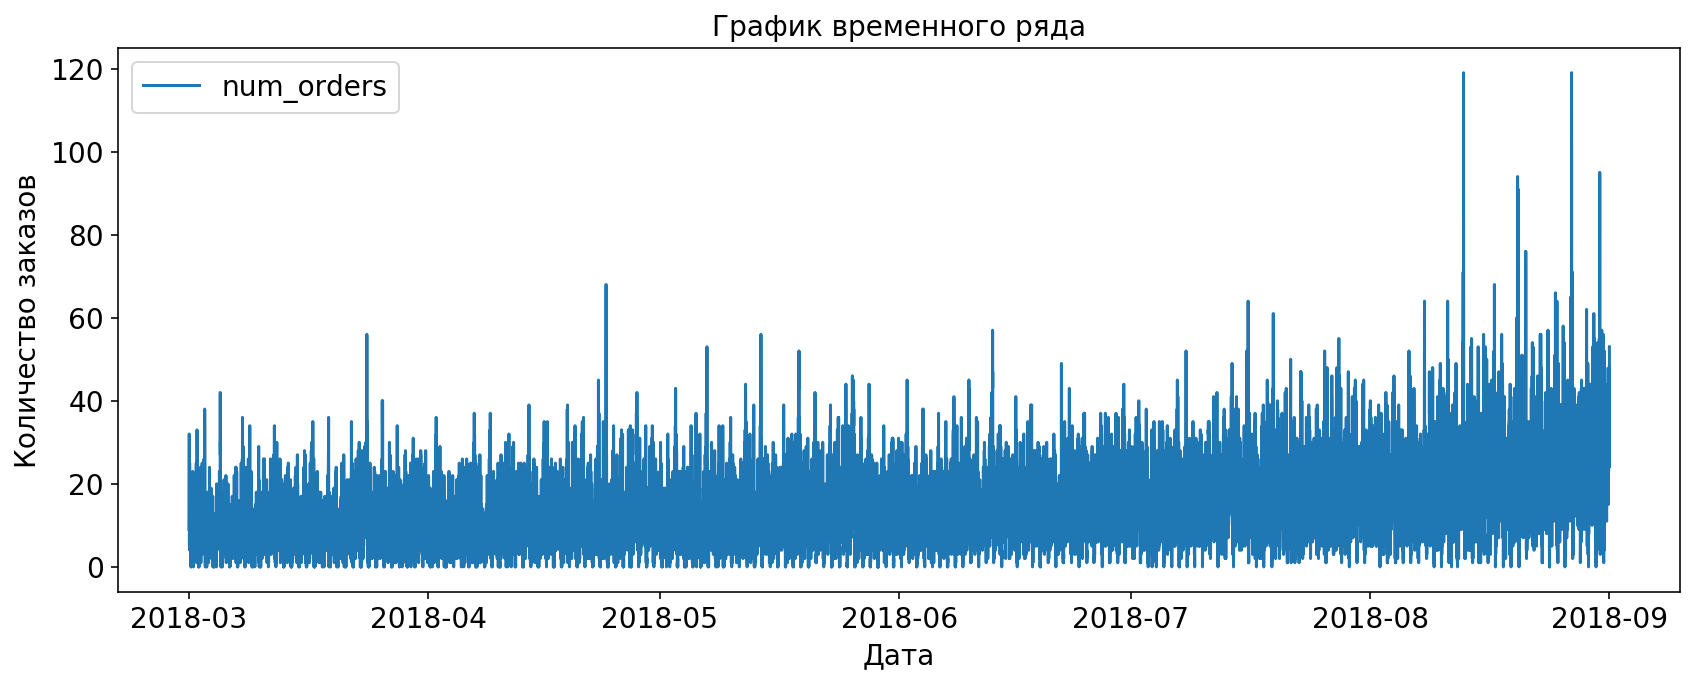

In [13]:
timeSeriesPlot(raw_taxi,'График временного ряда',"Дата","Количество заказов")

Нам необходимо сделать ресемплирование. 

## Вывод

В датафрейме 26496 обьектов, 1 столбец с типом *int64*. Пропущенных значений нету. Нам предоставили данные с *марта 2018 года по август 2018*. интервал между значениями ряда: **10 минут**. Данные в хронологическом порядке. Нам необходимо:
1. Предобработать данные:
    - Сделать ресемплирование
2. Провести анализ данных
3. Исследовать модели машинного обучения
    - Выбрать модель с самым лучшим показателем метрики RMSE на тестовой выборке.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'> 
    <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>есть контакт) данные на базе. План понятен.

<br>

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этом этапе нам необходимо сделать ресемплирование.

<a id="resample"></a>
## Ресемплирование

Сделаем ресемплирование данных по одному часу. Вычислим суммарные заказы

In [14]:
raw_taxi_resampled = raw_taxi.resample('1H').sum()

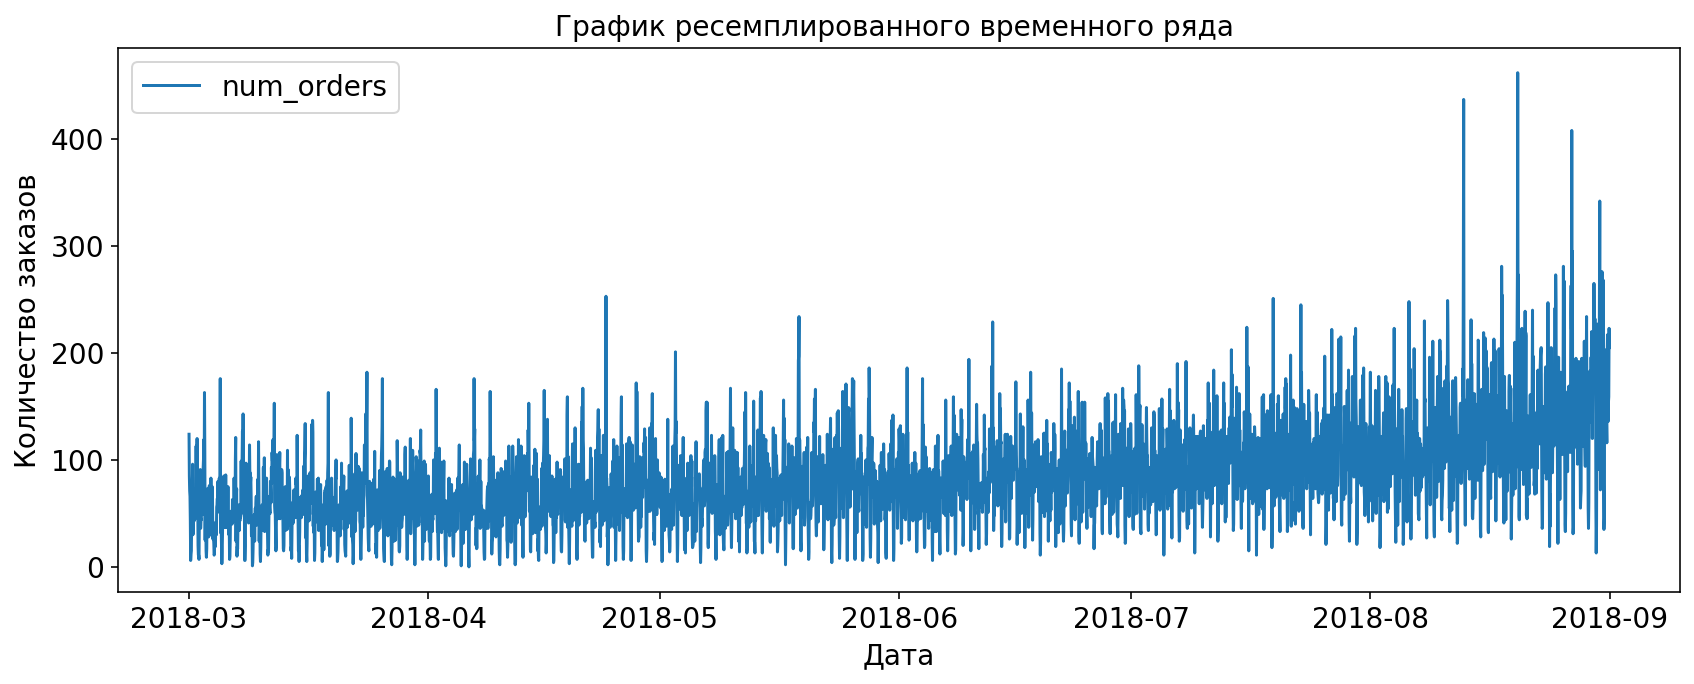

In [15]:
timeSeriesPlot(raw_taxi_resampled,'График ресемплированного временного ряда ',"Дата","Количество заказов")

<a id="dataCheck"></a>
## Финальная проверка данных

Напишем функцию которая проверит:
1. Пропущенные значения
3. Есть ли отрицательные значения
4. Соответствующие типы данных int64

In [16]:
def get_preprocessed_data(raw_data):
    """
    Функция проверяет данные. Возвращает предобработанные данные для обучения.
    raw_data - данные для проверки
    """
    # проверяем данные
    assert raw_data.isna().sum().sum() == 0, 'В данных не должно быть пропущенных значений!'
    assert raw_data.select_dtypes(exclude=[np.int64]).size == 0, 'Данные должны иметь только численный тип данных!'
    assert raw_data.min().min() == 0,'В данных не должно быть отрицательных значений!'
    print('Данные проверку прошли!')
    #создаем копию оригинального датафрейма
    preprocessed_data = raw_data.copy()
    
    return preprocessed_data

In [17]:
taxi = get_preprocessed_data(raw_taxi_resampled)

## Вывод

Сделали ресемплирование данных по одному часу. Данные прошли финальную проверку. Перейдём к анализу данных.

<a id="dataAnalysis"></a>
# Этап 3 - Анализ данных

На этом этапе нам необходимо провести анализ данных. Выявить тренды и сезонность. Также найдем скользящее среднее.

<a id="movingAverage"></a>
## Скользящее среднее

Чтобы сгладить временные ряды, воспользуемся скользящим средним. 

Напишем функцию для вывода скользящего среднего

In [18]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - столбец
        window - размер окна
        plot_intervals - вывести доверительный интервал
        plot_anomalies - вывести аномальные значения

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Скользящее среднее\n размер окна = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Вывод доверительных интервалов для сглаженных значений
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Найдя доверительные интервалы, выявим аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сглаживая временные ряды, можно определить тренды. Чем шире окно, тем плавнее тренд

Возьмём окно - 24ч - дневной тренд. 

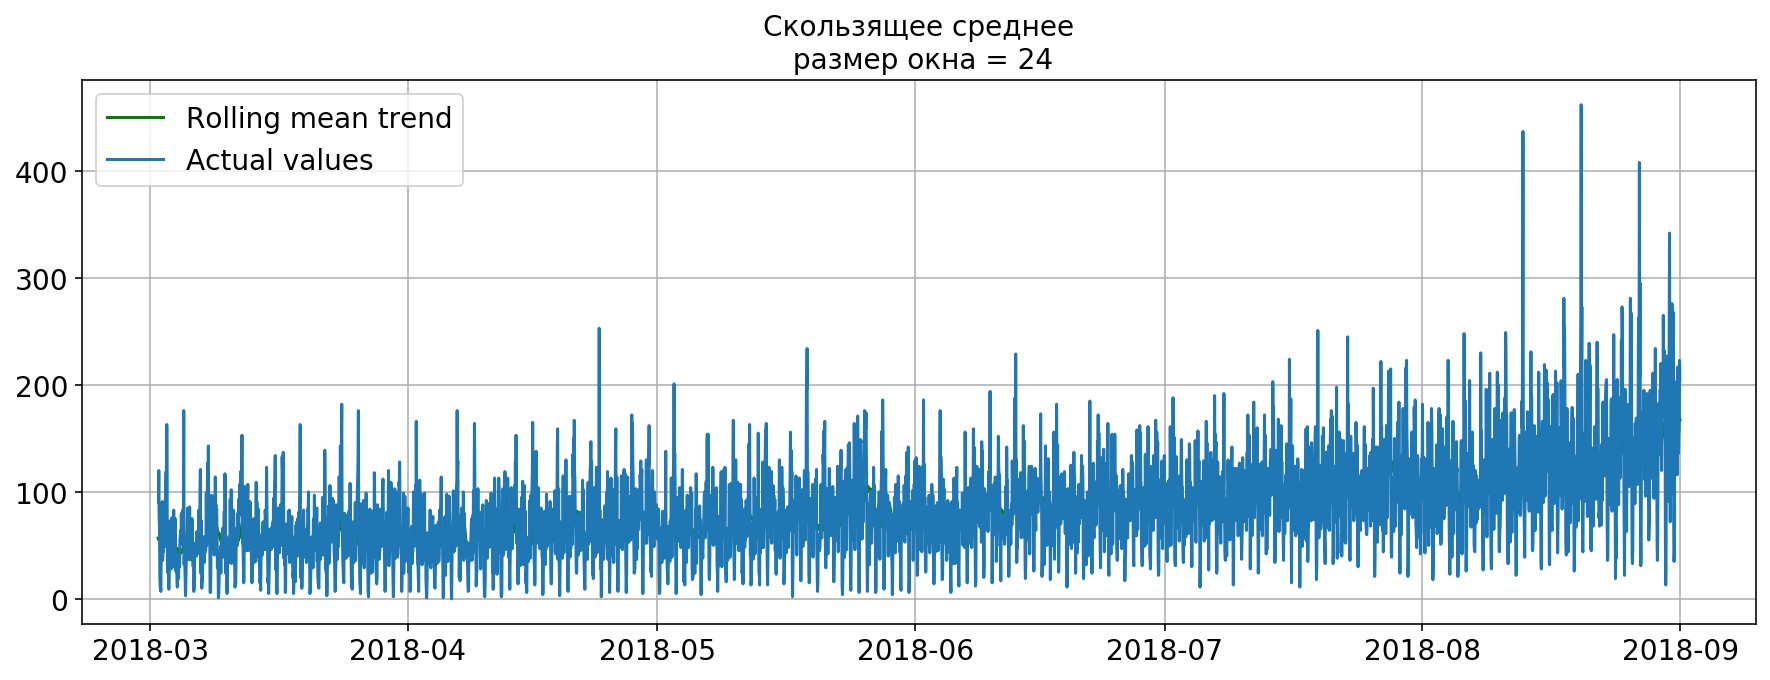

In [19]:
plotMovingAverage(taxi, 24)

Очень много шума, сделаем ресемплирование по дням и посмотрим на тренд

In [20]:
taxi_daily = taxi.resample('1D').sum()

Посмотрим на недельный тренд

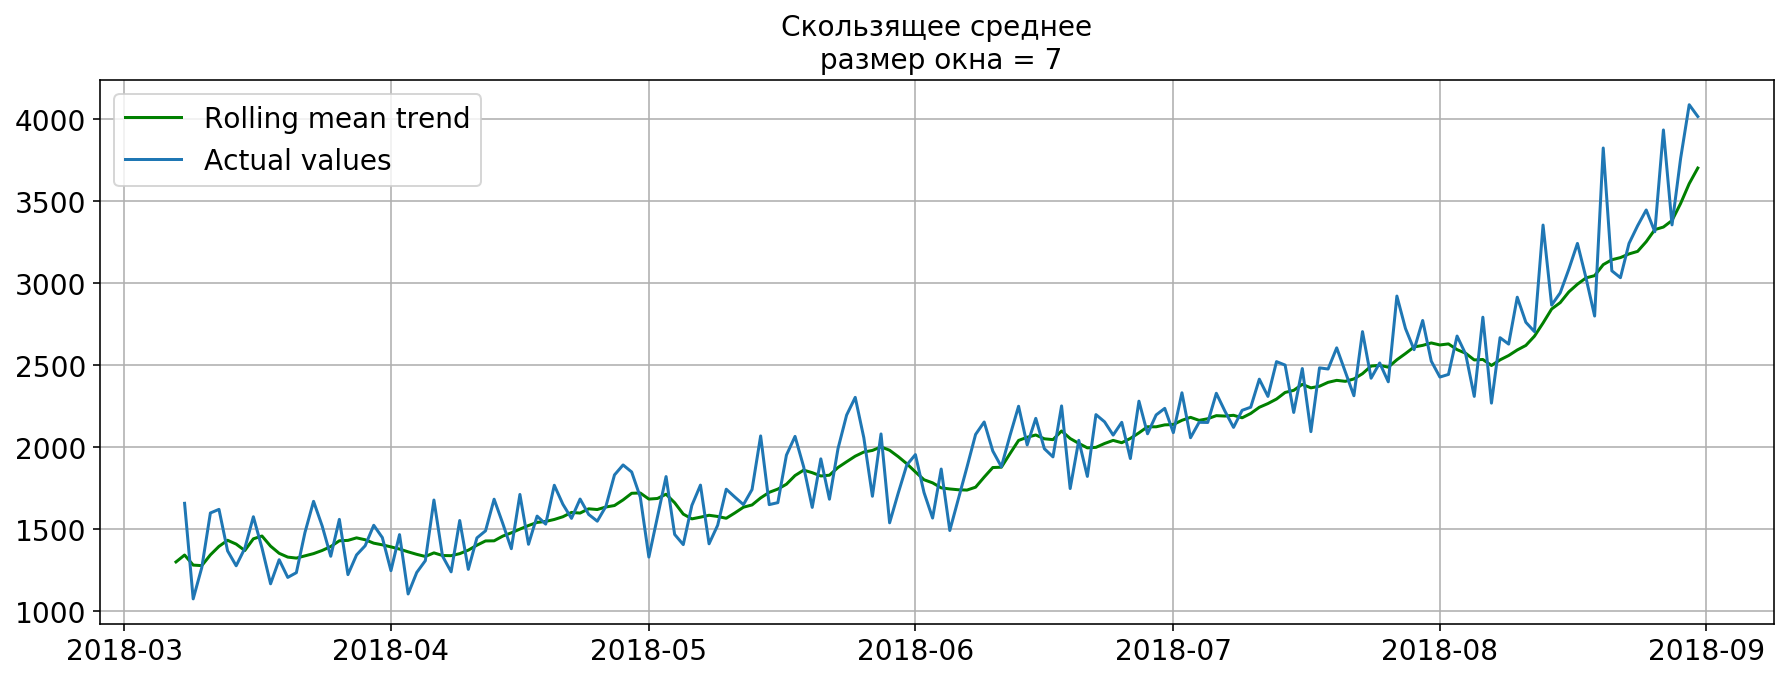

In [21]:
plotMovingAverage(taxi_daily, 7)

Выведём доверительные интервалы

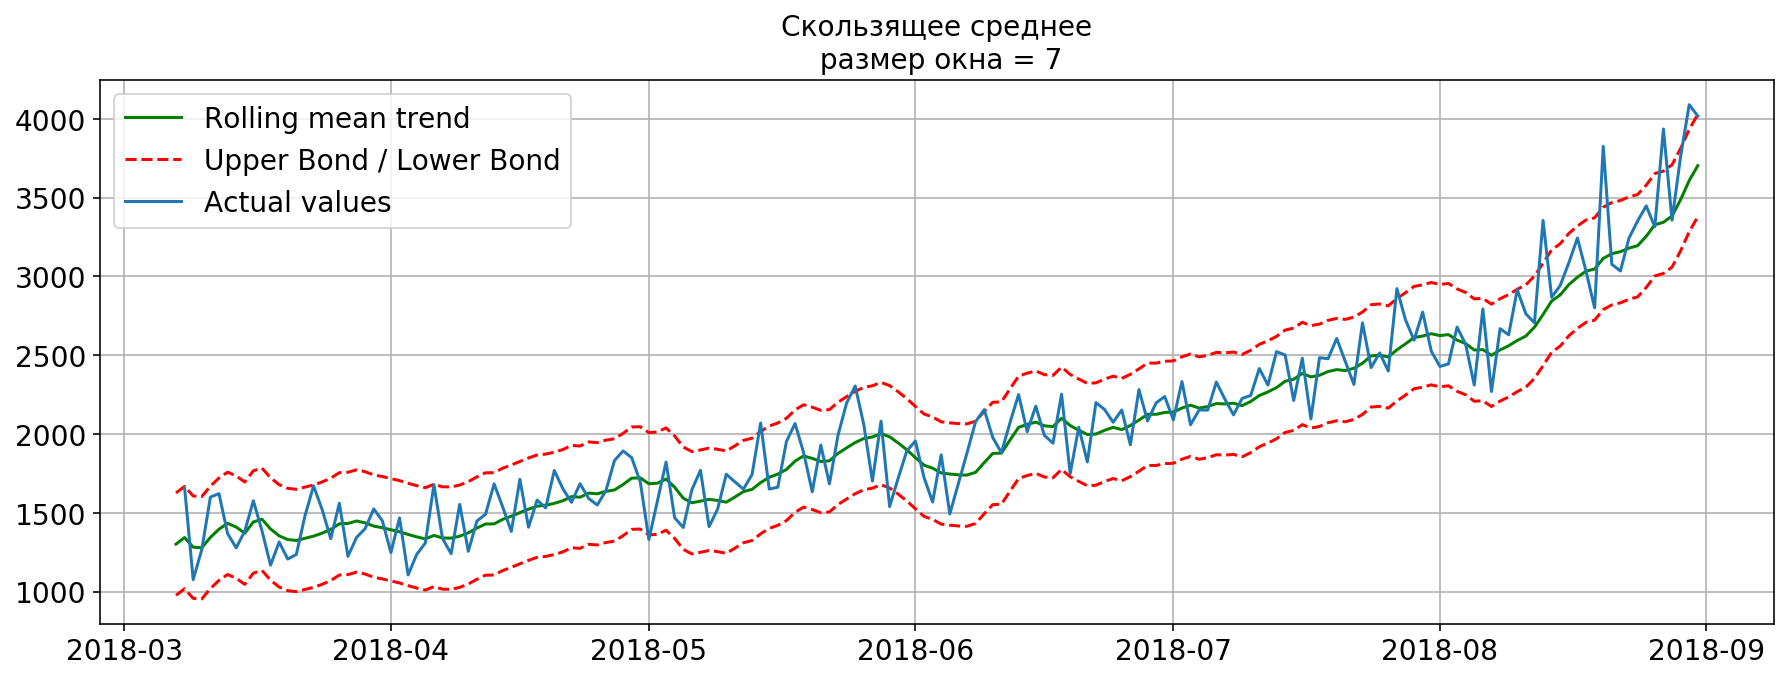

In [22]:
plotMovingAverage(taxi_daily, 7, True, True)

Аномальных значений не обнаружилось.

Возьмем выборку за первый месяц, и  последний 

In [23]:
march = taxi['2018-03-01': '2018-03-31']

In [24]:
august = taxi['2018-08-01': '2018-08-31']

## Первый месяц

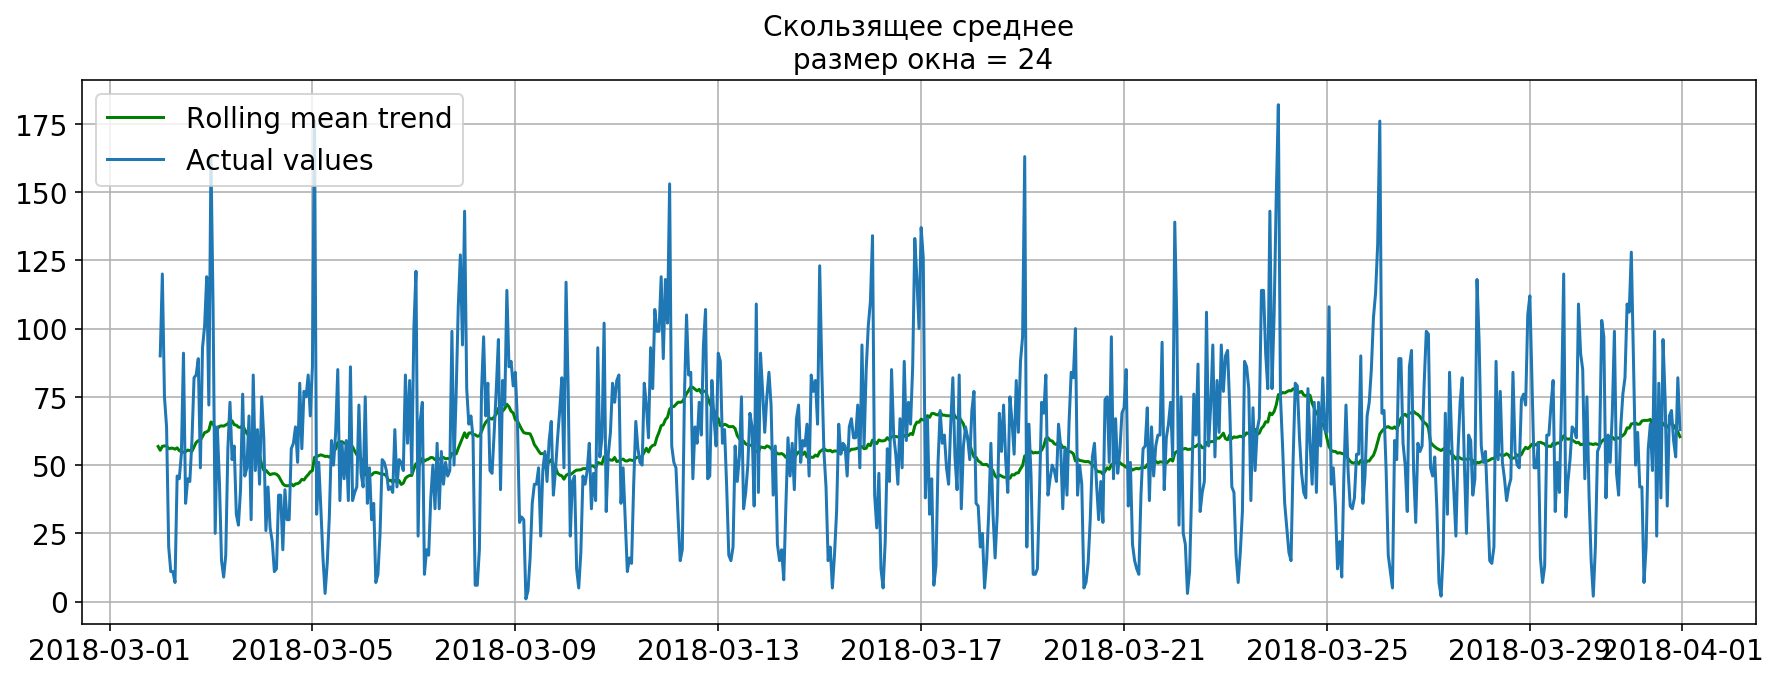

In [25]:
plotMovingAverage(march, 24)

В первом месяце скользящее среднее изменялось в диапазоне от 45 до 75 заказов в день

Возьмём первую и последнюю неделю марта

In [26]:
march_first_week = march['2018-03-01':'2018-03-07']
march_last_week = march['2018-03-24':'2018-03-31']

### Первая неделя

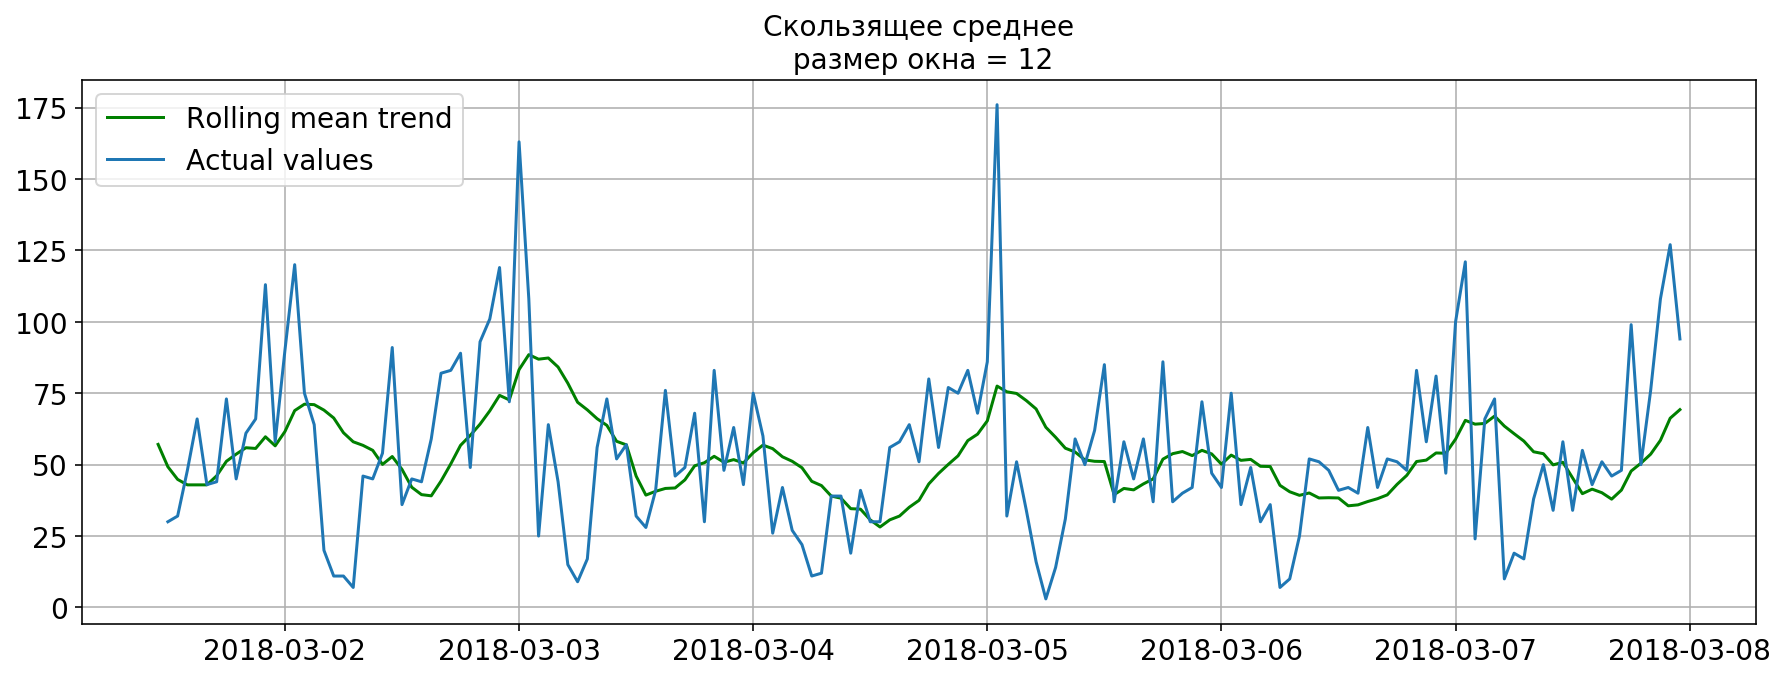

In [27]:
plotMovingAverage(march_first_week, 12)

В первой неделе Марта, можем увидеть преобладающее количество заказов в субботу и понедельник. Увидем ли тоже самое и в последней неделе Марта?

Посмотрим на субботу и понедельник

In [28]:
march_first_week_saturday = march_first_week['2018-03-03']
march_first_week_monday = march_first_week['2018-03-05']

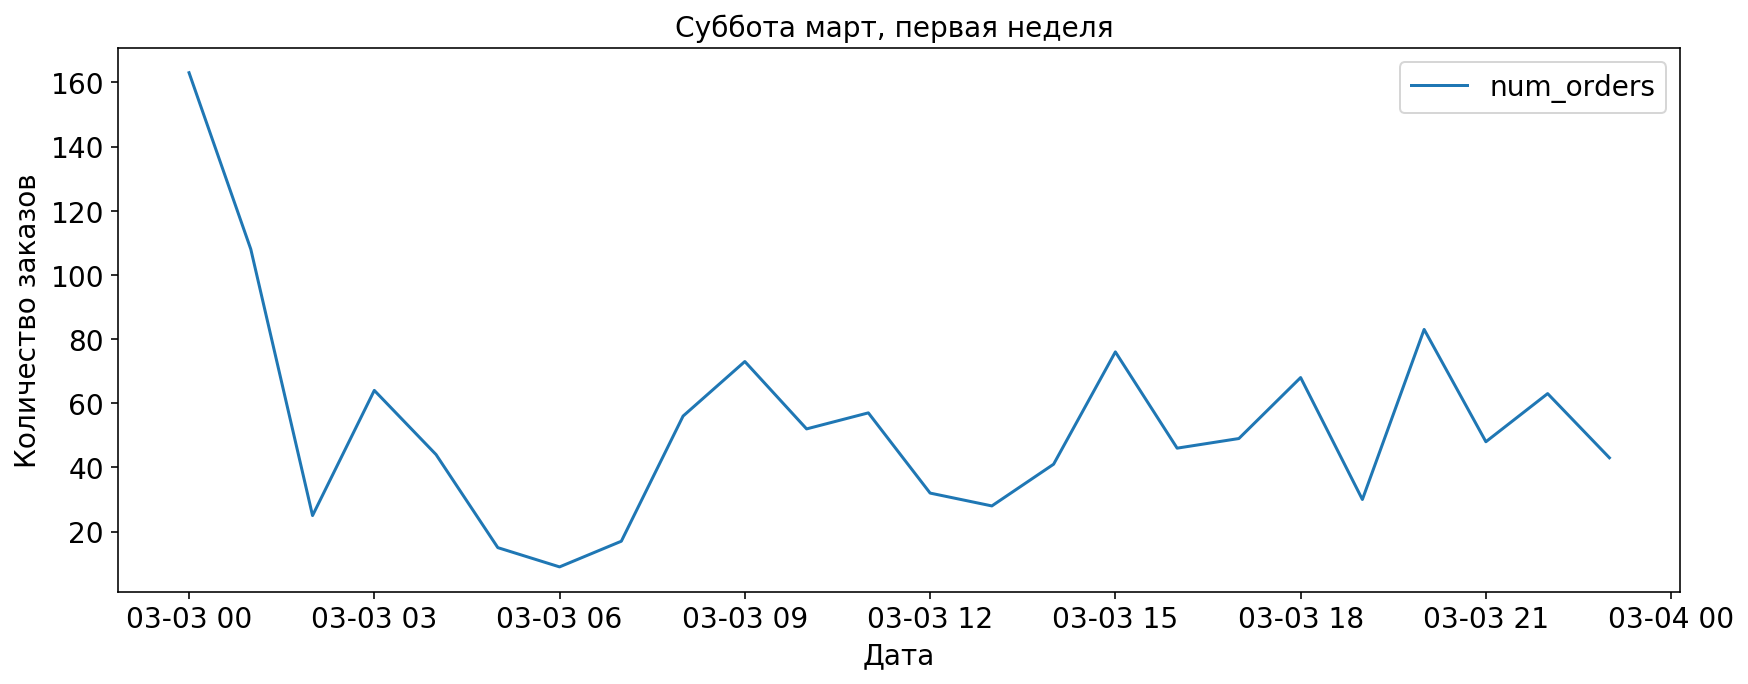

In [29]:
timeSeriesPlot(march_first_week_saturday,'Суббота март, первая неделя ',"Дата","Количество заказов")

Большинство заказов было в полночь. Также, видим количество заказов возрастает утром в 9:00 утра, 15:00 дня, 20:00 вечера.

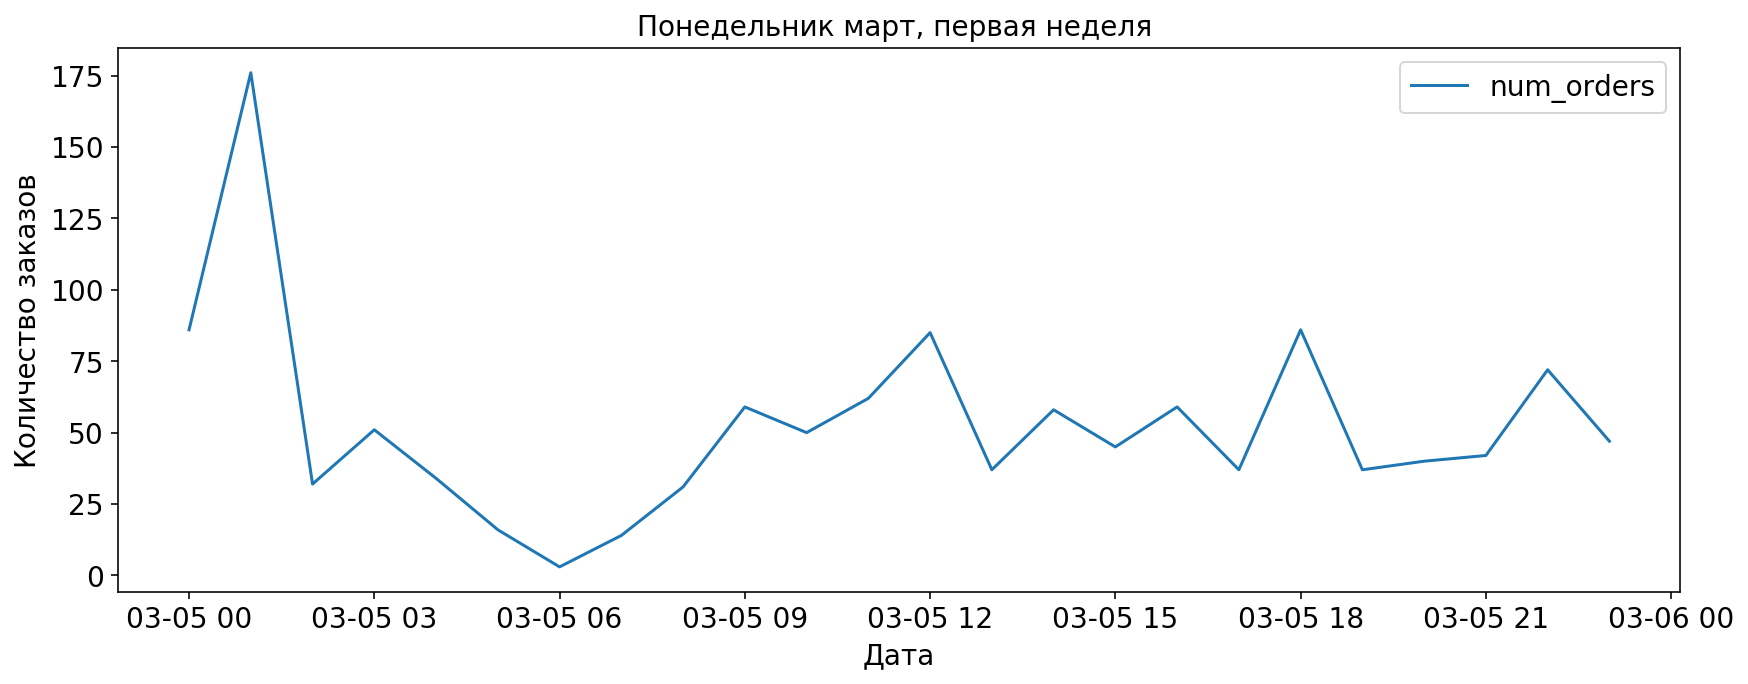

In [30]:
timeSeriesPlot(march_first_week_monday,'Понедельник март, первая неделя ',"Дата","Количество заказов")

Также видим всплеск заказов в полночь. Получается такси больше используют ночью ?? Количество заказов возрастает в 12:00 дня, 18:00 вечера.

### Последняя неделя 

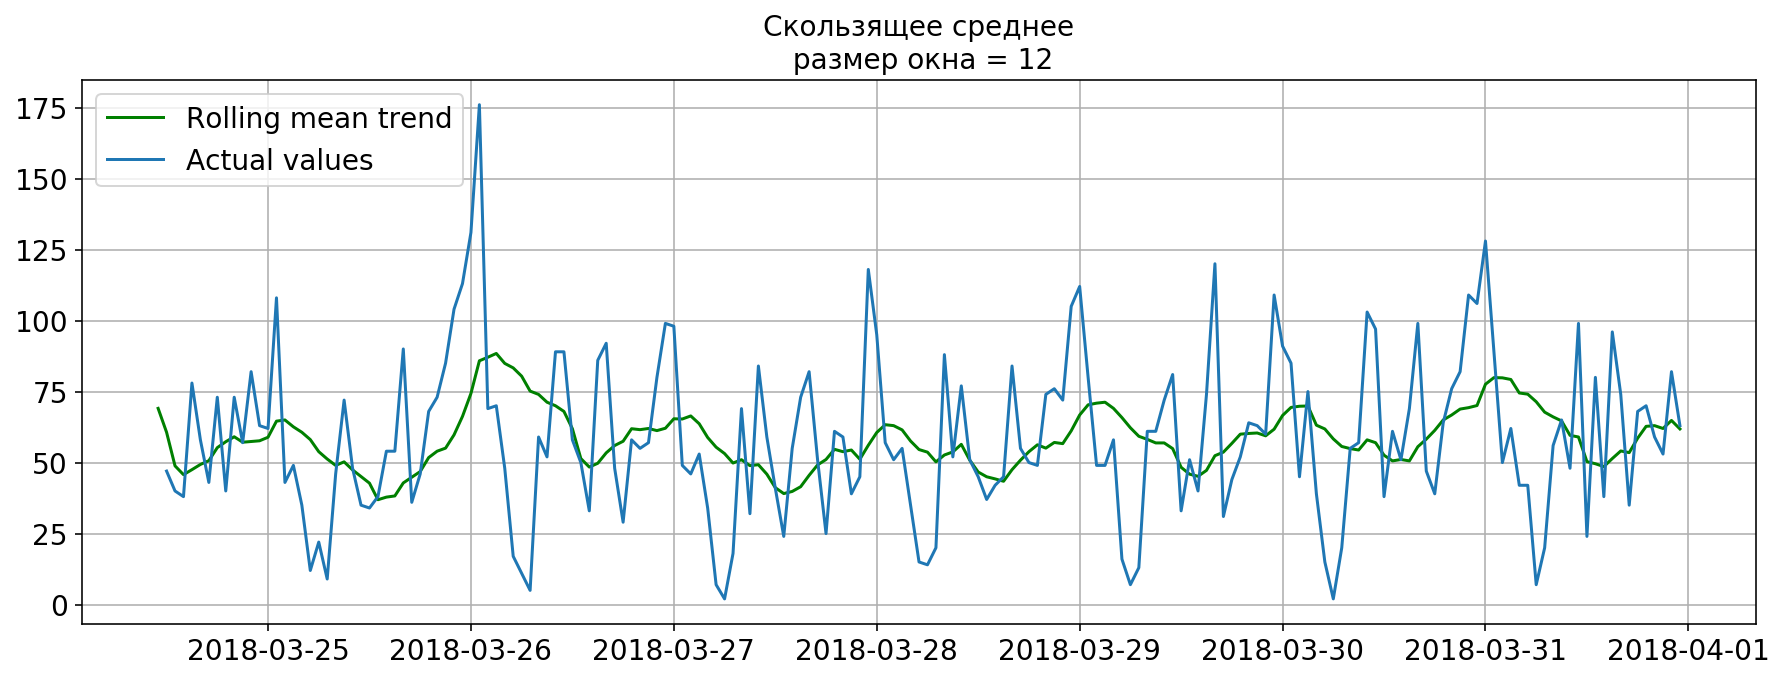

In [31]:
plotMovingAverage(march_last_week, 12)

Большое количество заказов приходиться на понедельник. 

In [32]:
march_last_week_monday = march_last_week['2018-03-26']

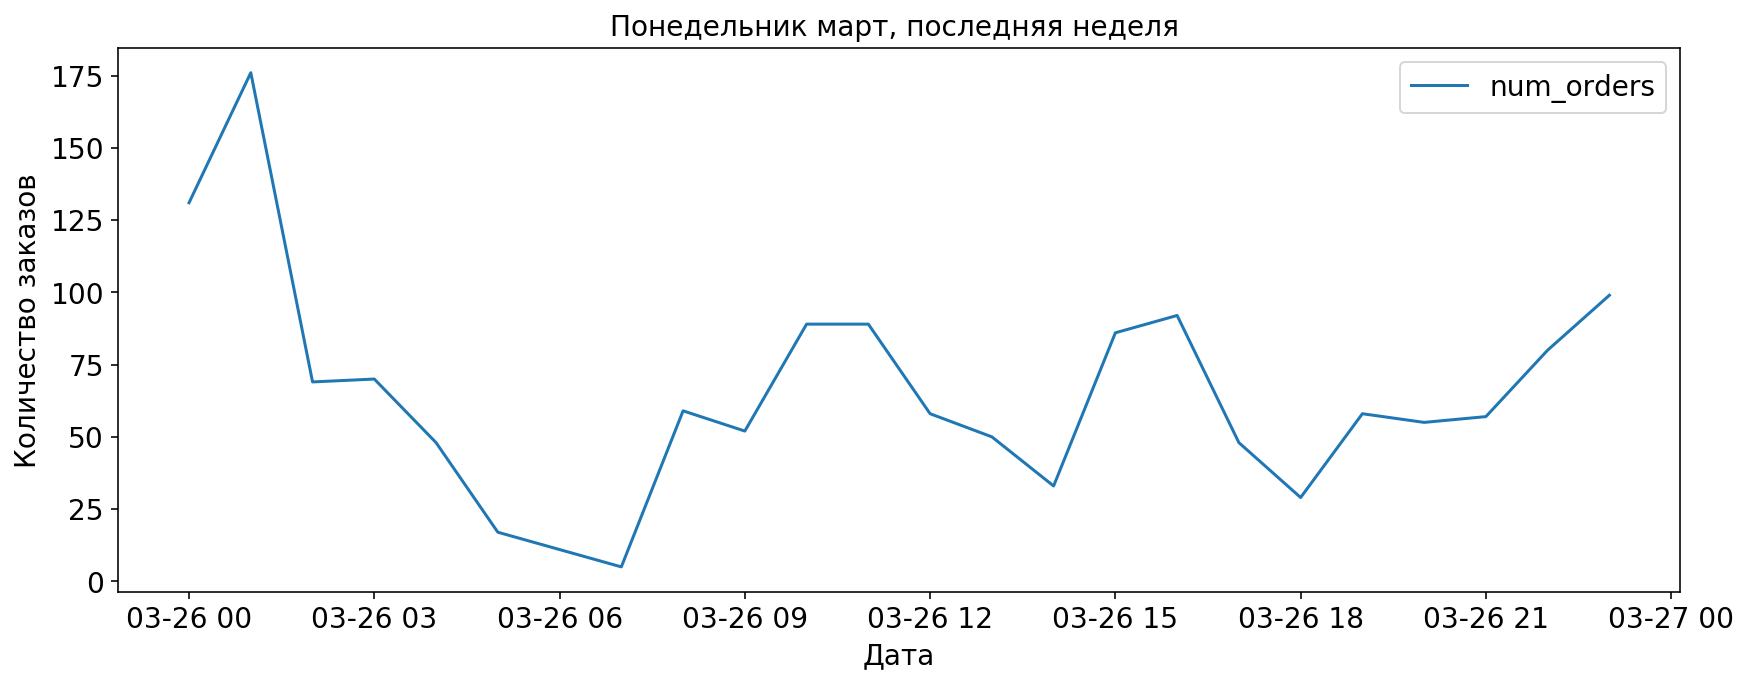

In [33]:
timeSeriesPlot(march_last_week_monday,'Понедельник март, последняя неделя ',"Дата","Количество заказов")

Да видимо какой-то тренд - заказывать такси ночью. Количество заказов возрастает в 10:00-11:00 утра, 15:00-16:00 дня, и 22:00-23:00 вечера.

## Последний месяц

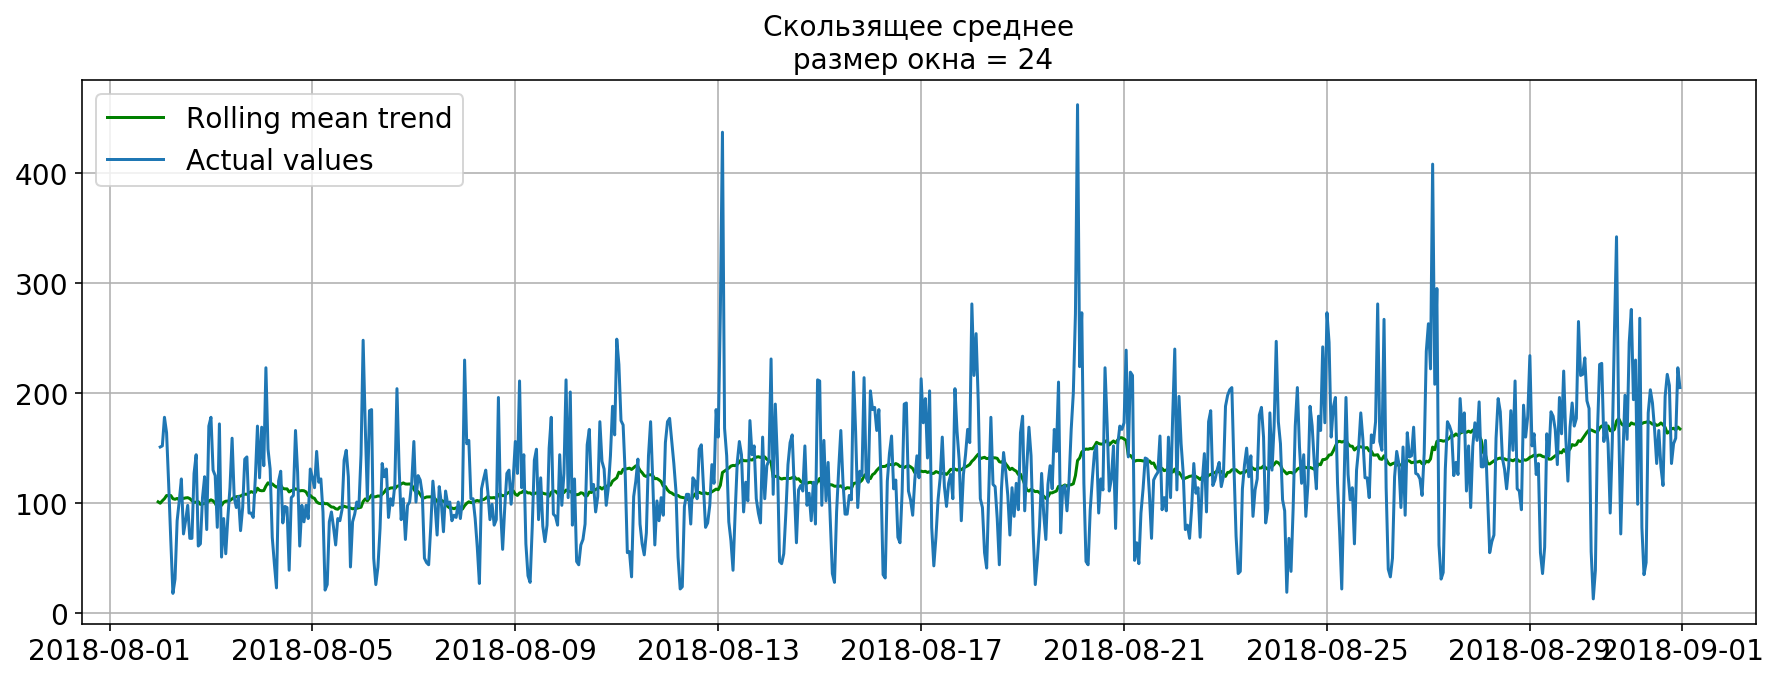

In [34]:
plotMovingAverage(august, 24)

Как видим,диапазон у скользящего среднего увеличился от 100 до 200 заказов в день.

Возьмём первую и последнюю неделю августа

In [35]:
august_first_week = august['2018-08-01':'2018-08-07']
august_last_week = august['2018-08-24':'2018-08-31']

### Первая неделя

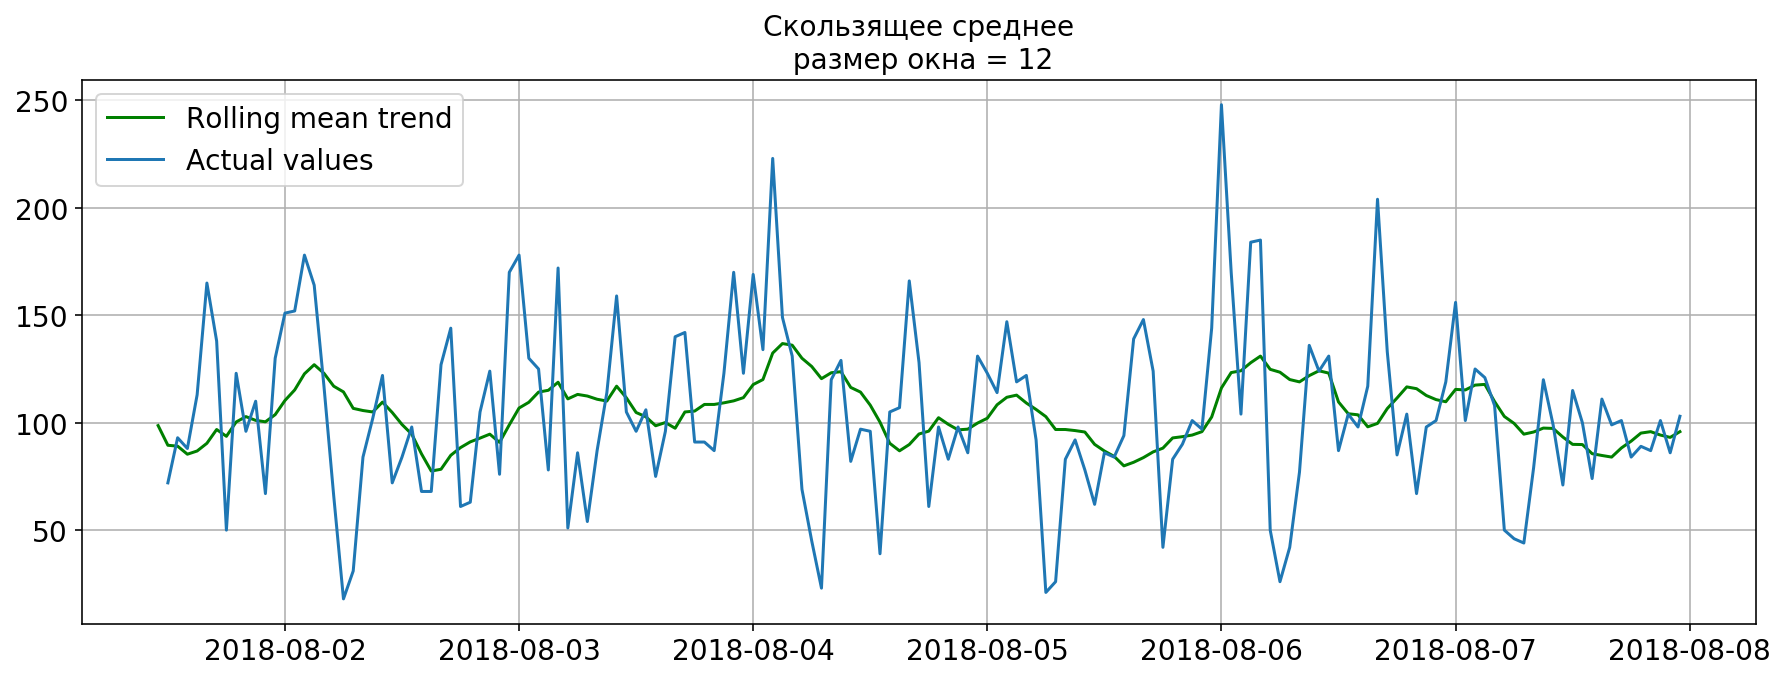

In [36]:
plotMovingAverage(august_first_week, 12)

Видим всплеск заказов в субботу и в понедельник. Посмотрим будет ли тоже самое и в последней недели?

Посмотрим на субботу и понедельник.

In [37]:
august_first_week_saturday = march['2018-03-04']
august_first_week_monday = march['2018-03-06']

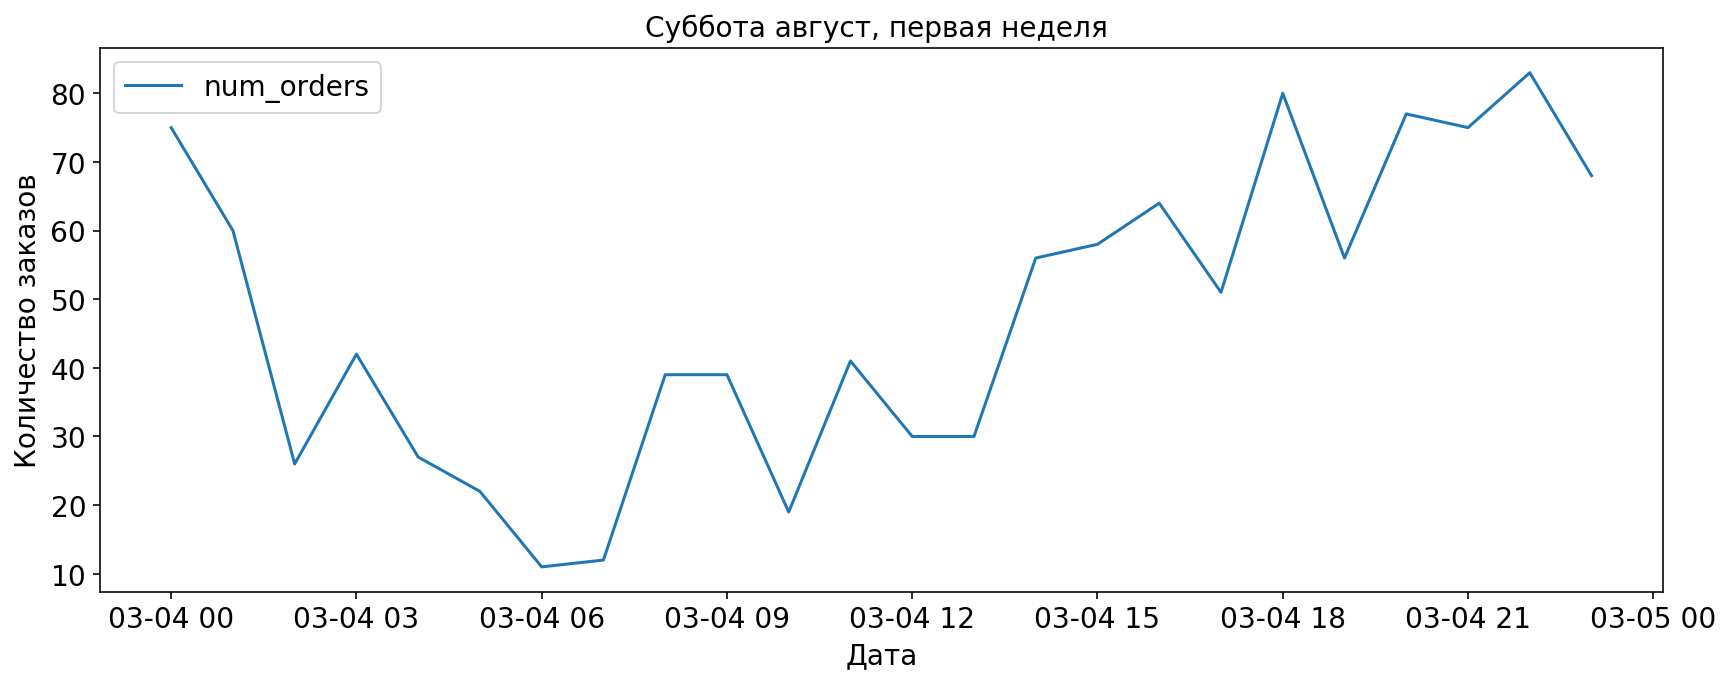

In [38]:
timeSeriesPlot(august_first_week_saturday,'Суббота август, первая неделя ',"Дата","Количество заказов")

Ого, видим количество заказов возрастает вечером. 

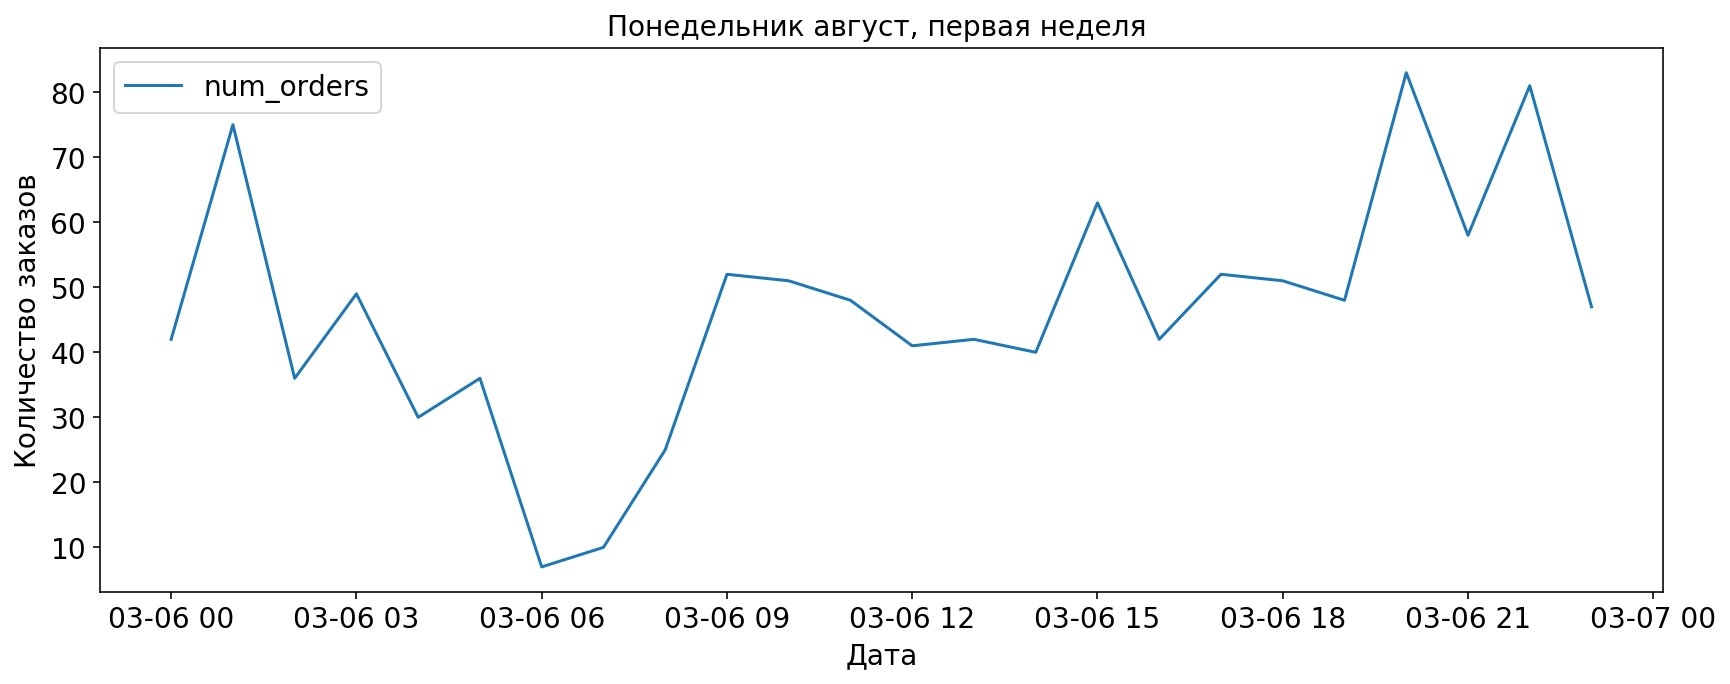

In [39]:
timeSeriesPlot(august_first_week_monday,'Понедельник август, первая неделя ',"Дата","Количество заказов")

Примерно, такую же ситуацию видим и в понедельник.

### Последняя неделя 

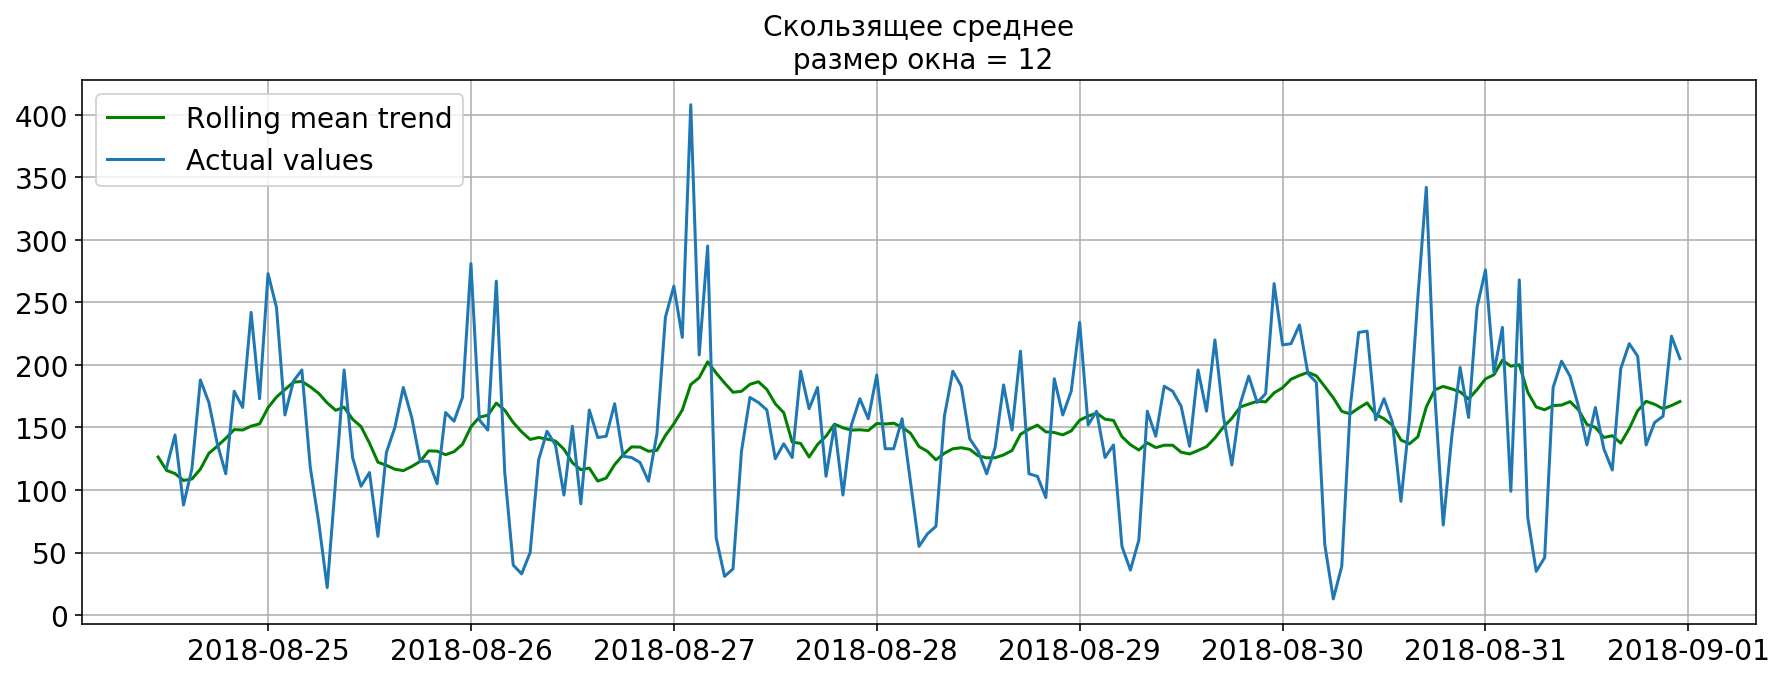

In [40]:
plotMovingAverage(august_last_week, 12)

Большое количество заказов приходится на понедельник.

In [41]:
august_last_week_monday = march['2018-03-27']

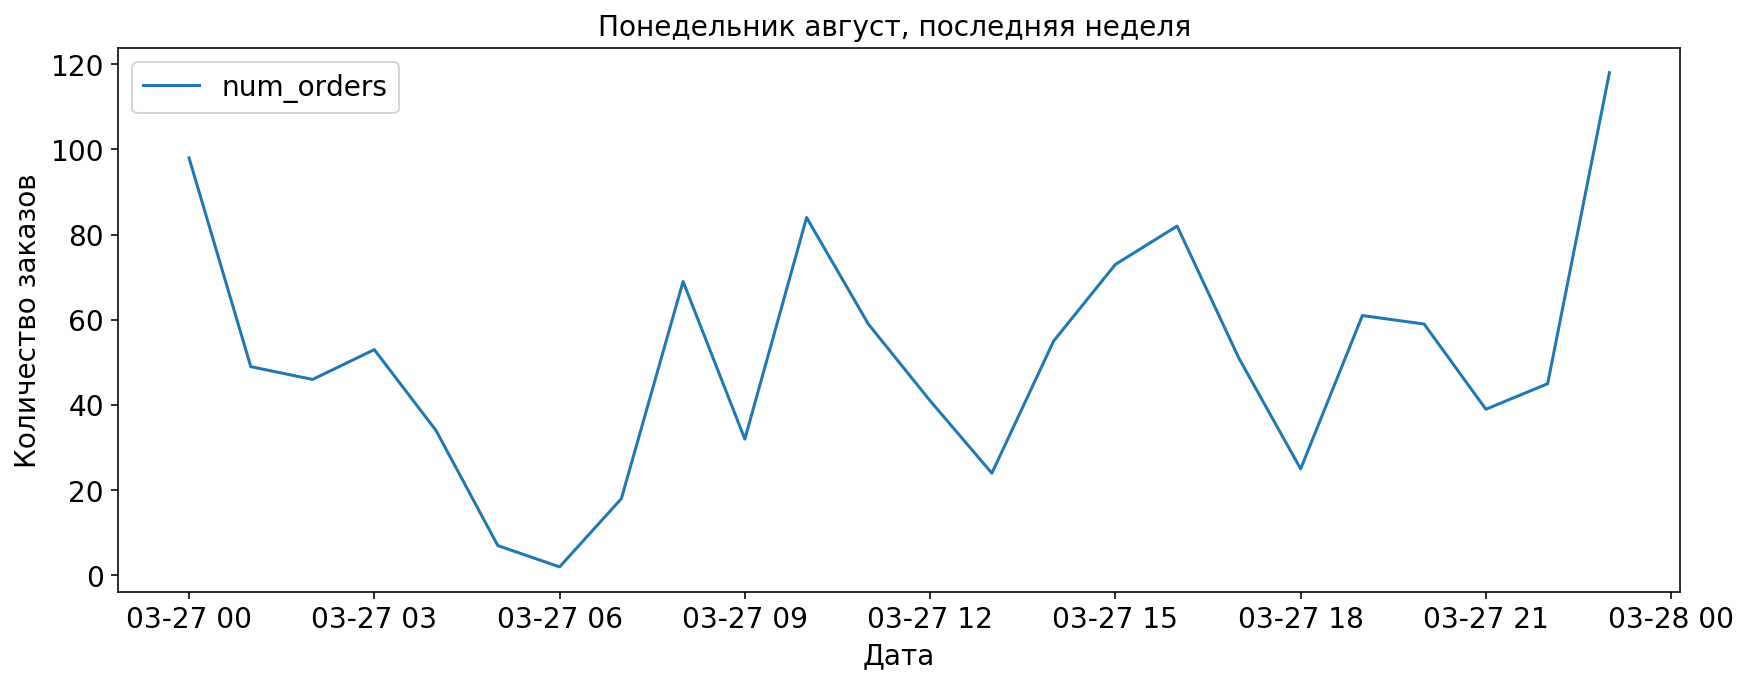

In [42]:
timeSeriesPlot(august_last_week_monday,'Понедельник август, последняя неделя ',"Дата","Количество заказов")

Тут уже видим, люди использую такси утром 09:00-10:00 часов, в обед (14:00-15:00), и вечером 22:00-23:00

Посмотрев данные за первый и последний месяц, у меня появилась гипотеза: такси часто используют вечером и ночью, также по дням: в понедельник и субботу.

Перейдём к трендам.

<a id="trend"></a>
## Тренд

Воспользуемся методом seasonal_components() библиотеки statsmodels

In [43]:
decomposed = seasonal_decompose(taxi_daily)

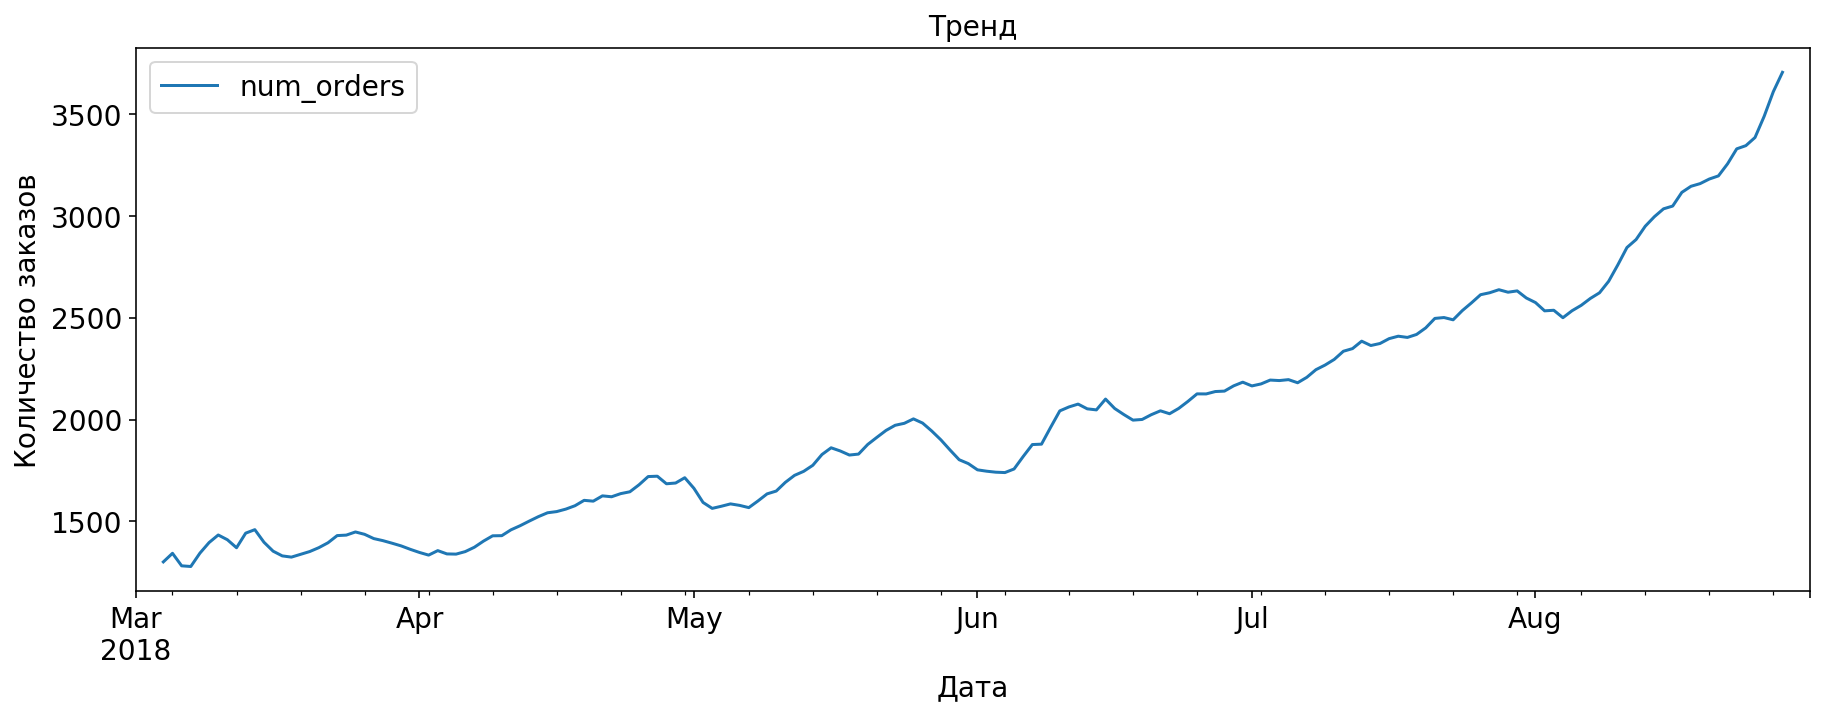

In [44]:
plt.figure(figsize=(15, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.show()

Мы видим, что у нас идет ежемесячное увеличение количество заказов такси.

<a id="seasonal"></a>
## Сезонность

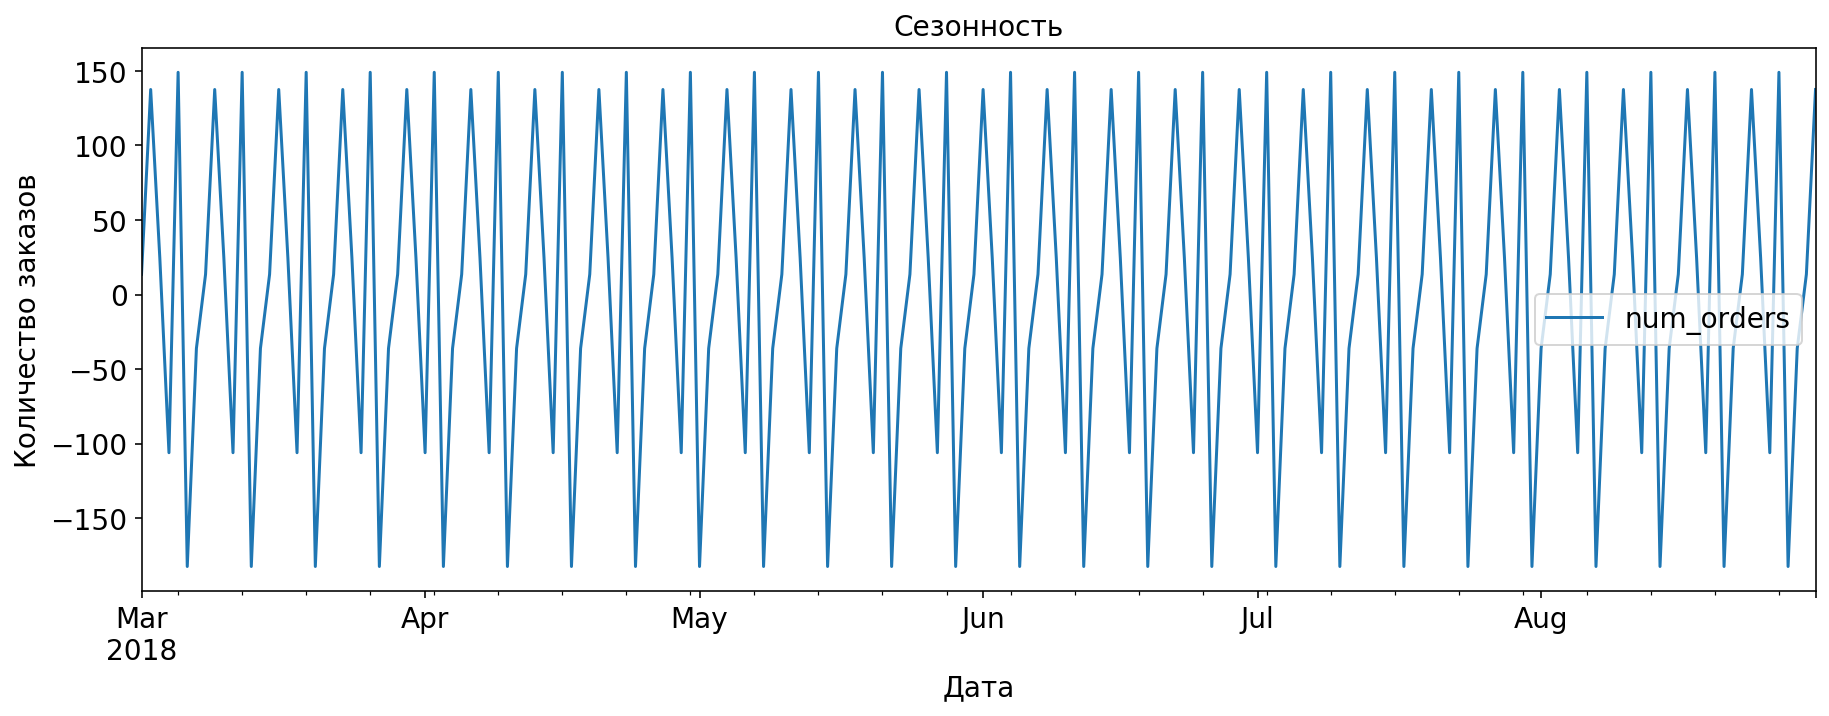

In [45]:
plt.figure(figsize=(15, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.show()

Сезонность пока что необьяснима. Возьмём интервалы. Первый и последний месяц

In [46]:
march_decomposed = decomposed.seasonal['2018-03-01': '2018-03-31']
august_decomposed = decomposed.seasonal['2018-08-01': '2018-08-31']

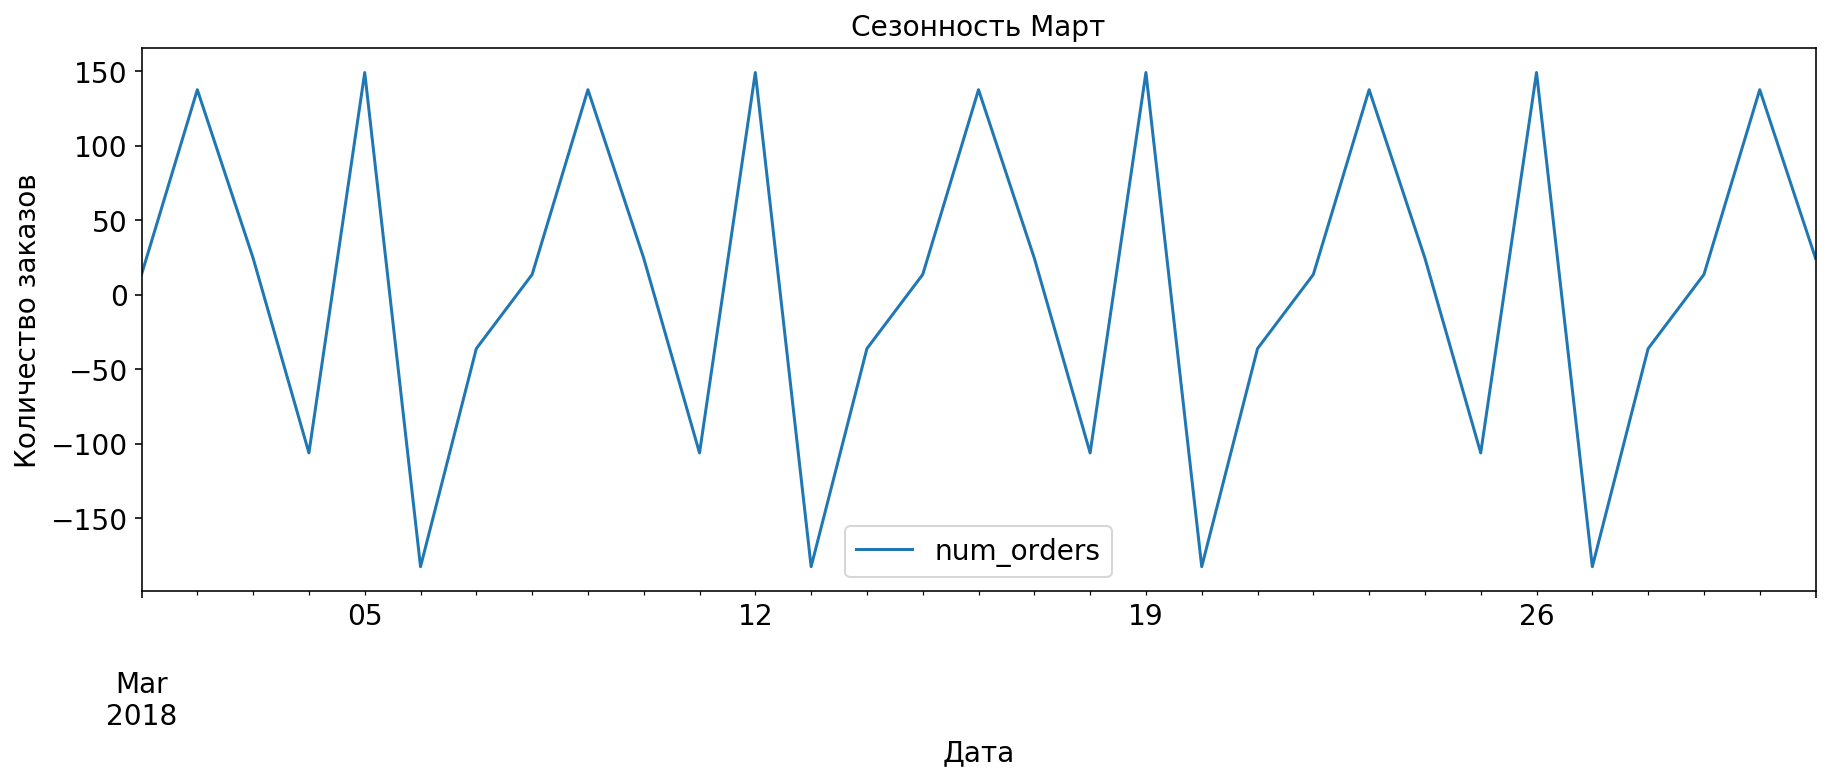

In [47]:
plt.figure(figsize=(15, 5))
march_decomposed.plot(ax=plt.gca())
plt.title('Сезонность Март')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.show()

Количество заказов падает по понедельникам...

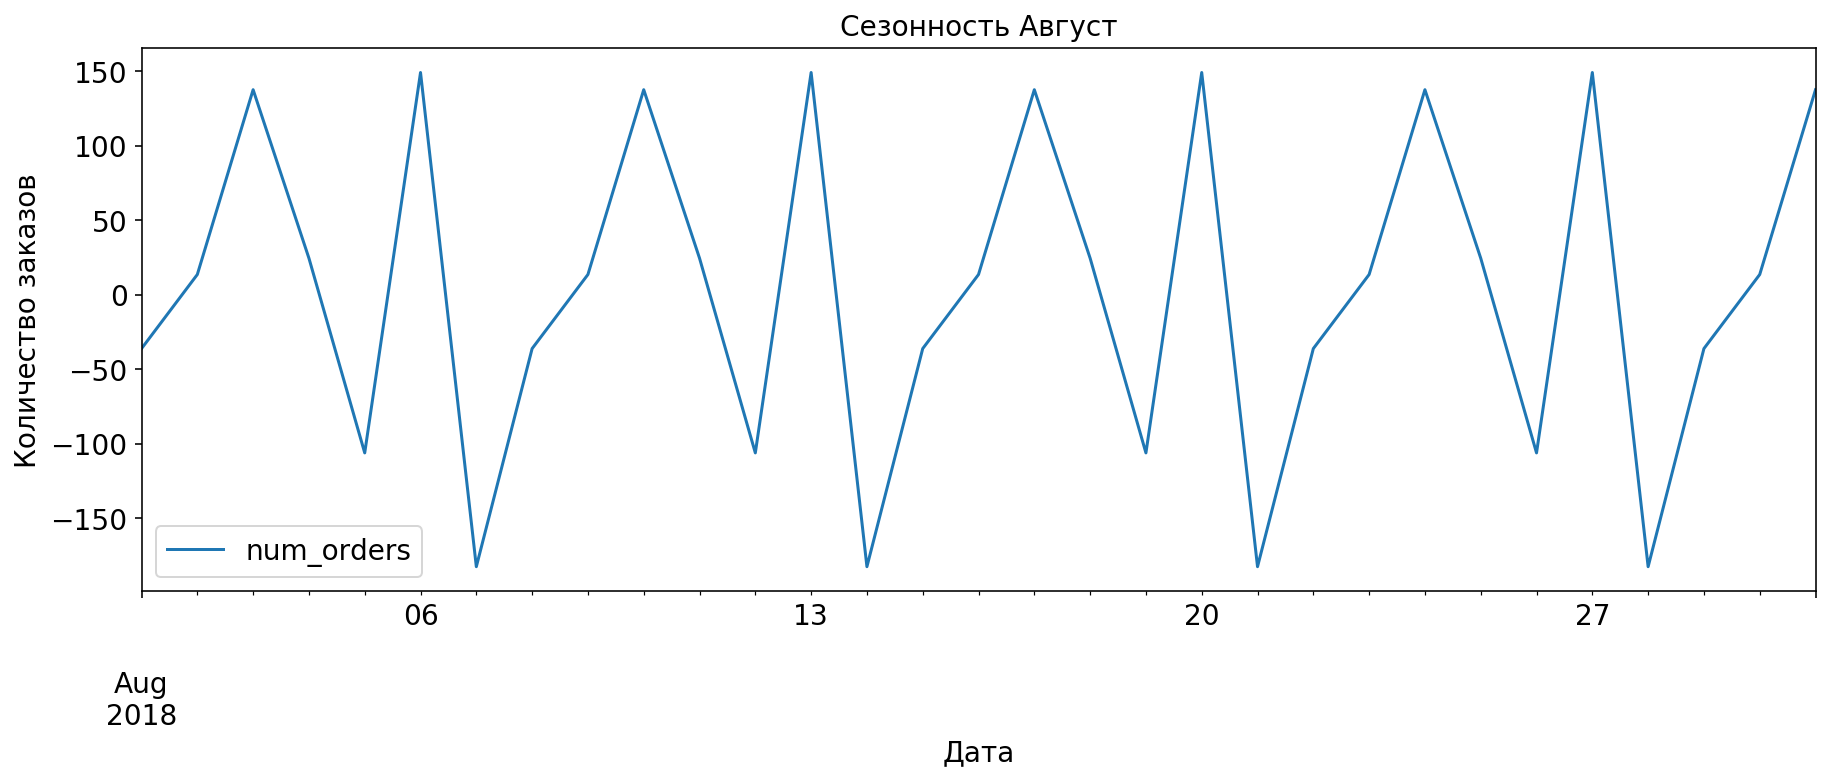

In [48]:
plt.figure(figsize=(15, 5))
august_decomposed.plot(ax=plt.gca())
plt.title('Сезонность Август')
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.show()

Тоже самое видим, по средам, количество заказов падает.

## Вывод

Мы провели анализ данных. Аномальных значений не обнаружилось. 

Скользящее среднее:
- В первом месяце скользящее среднее изменялось в диапазоне от 45 до 75 заказов в день
- В первой неделе Марта, можем увидеть преобладающее количество заказов в субботу и понедельник.
- Суббота: большинство заказов было в полночь. Также, количество заказов возрастает утром в 9:00 утра, 15:00 дня, 20:00 вечера.
- Понедельник: всплеск заказов в полночь. Получается такси больше используют ночью ?? Количество заказов возрастает в 12:00 дня, 18:00 вечера.
- Последняя неделя Марта, большое количество заказов приходиться на понедельник. 
- Понедельник: Количество заказов возрастает в 10:00-11:00 утра, 15:00-16:00 дня, и 22:00-23:00 вечера.
- Мы обнаружили тренд - люди часто заказывают такси ночью. 
- В последнем месяце, диапазон у скользящего среднего увеличился от 100 до 200 заказов в день.
- Первая неделя последнего месяца: всплеск заказов в субботу и в понедельник.
- Суббота: количество заказов возрастает вечером. 
- Количество заказов возрастает вечером и в понедельник.
- Последняя неделя: большое количество заказов приходится на понедельник.
- Понедельник: люди используют такси утром 09:00-10:00 часов, в обед (14:00-15:00), и вечером 22:00-23:00

Посмотрев данные за первый и последний месяц, у меня появилась гипотеза: такси часто используют вечером и ночью, также по дням: в понедельник и субботу.

Тренд:
- идет ежемесячное увеличение количество заказов такси.

Сезонность:
- Количество заказов падает по понедельникам и средам...




<a id="featureEngineering"></a>
# Этап 4 - Feature Engineering

Создадим признаки для прогнозирования. Добавим следующие признаки: 
1. Календарные 
2. Отстающие значения
3. Скользящее среднее

In [49]:
def make_features(data, max_lag, rolling_mean_size):
    """
    Функция создания признаков для временных рядов.
    data - датафрейм
    max_lag - максимальный размер отставания
    rolling_mean_size - ширина окна
    """
    # Календарные признаки
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.index.weekday.isin([5,6])*1
    data['hour'] = data.index.hour
    
    # Отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

In [50]:
make_features(taxi, 1, 24)

In [51]:
taxi.head()

## Разделение данных

Нам необходимо проверить модель на правильные предсказания. Для этого мы разделим общую выборку на 2 части в соотношении (*90/10*): обучающую, тестовую.

In [52]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [53]:
train = train.dropna()
test = test.dropna()

Напишем функцию разделения целевого признака от остальных.

In [54]:
def target_features_split(data,column):
    """
    Функция разделяет данные на целевой признак и признаки. Функция возвращает 1) целевой признак, 2) признаки без целевого
    data - данные которые необходимо разделить.
    column - целевой признак
    """
    return data[column], data.drop(column,axis=1)

In [55]:
target_train, features_train = target_features_split(train, 'num_orders')
target_test, features_test = target_features_split(test, 'num_orders')

## Вывод

Мы добавили признаки: 
1. Календарные 
2. Отстающие значения
3. Скользящее среднее

Также, разделили общую выборку на 2 части в соотношении (*90/10*): обучающую, тестовую. Отделили целевой признак.

<a id="MLmodelResearch"></a>
# Этап 5 - Исследование моделей машинного обучения

Исследуем разные модели регрессии: Линейная регрессия, Дерево решений, Рандомный лес. Также посмотрим модели бустингов.  Посмотрим на значение метрики: RMSE,MAPE

Мы будем вести учёт моделей машинного обучения. Создадим лист моделей с помощью словаря. Потом из словаря преобразуем таблицу моделей со всеми метриками. 

In [56]:
ml_models_stats = dict()

In [57]:
tscv = TimeSeriesSplit(n_splits=8)

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Напишем функцию для оценки моделей.

In [59]:
def evaluate_model(model_name, model, train_features, train_target, test_features, test_target,parameters=None):
    """
    Функция оценивает модель по метрикам RMSE,MAPE, добавляет модель в таблицу со метриками RMSE,MAPE.
    model_name - имя модели
    model - сама модель
    train_features - обучающая выборка признаки
    train_target - обучающая выборка целевой признак
    test_features - тестовая выборка признаки
    test_target - тестовая выборка целевой признак
    parameters - параметры модели
    """
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    print()
    
    # генерируем предсказания
    predicted_test = model.predict(test_features)
    predicted_train = model.predict(train_features)
    # MSE - средняя квадратичная ошибка
    mse_test = mean_squared_error(test_target, predicted_test)
    mse_train = mean_squared_error(train_target, predicted_train)
    # MAPE - средняя абсолютная процентная ошибка
    mape_test = mean_absolute_percentage_error(predicted_test, test_target)
    mape_train = mean_absolute_percentage_error(predicted_train, train_target)
    # RMSE - квардратный корень из средней квадратичной ошибки
    rmse_test = mse_test ** 0.5
    rmse_train = mse_train ** 0.5
    # вывод значений метрик
    print(f'RMSE модели на тестовой выборке: {rmse_test}')
    print(f'RMSE модели на обучающей выборке: {rmse_train}')
    print(f'MAPE модели на тестовой выборке: {mape_test}')
    print(f'MAPE модели на обучающей выборке: {mape_train}')
    plotModelResults(model,train_features, train_target, test_features, test_target,True,False)
    # добаляем модель
    ml_models_stats[model_name] = {
        'название': model_name,
        'rmse_train':rmse_train,
        'rmse_test':rmse_test,
        'mape_train':mape_train,
        'mape_test':mape_test
    }
    print()
    print('Модель успешно добавлена в таблицу!')

In [60]:
def plotModelResults(model, X_train, Y_train ,X_test, Y_test,plot_intervals=False, plot_anomalies=False):
    """
        Вывод результатов модели на графике
        model - модель
        X_train - обучающая выборка признаки
        Y_train - обучающиая выборка целевой признак
        X_test - тестовая выборка признаки
        Y_test - тестовая выборка целевой признак
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(Y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, Y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(Y_test))
            anomalies[Y_test<lower] = Y_test[Y_test<lower]
            anomalies[Y_test>upper] = Y_test[Y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, Y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [61]:
random_state_val = 42

## Линейная Регрессия

In [62]:
%%time
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

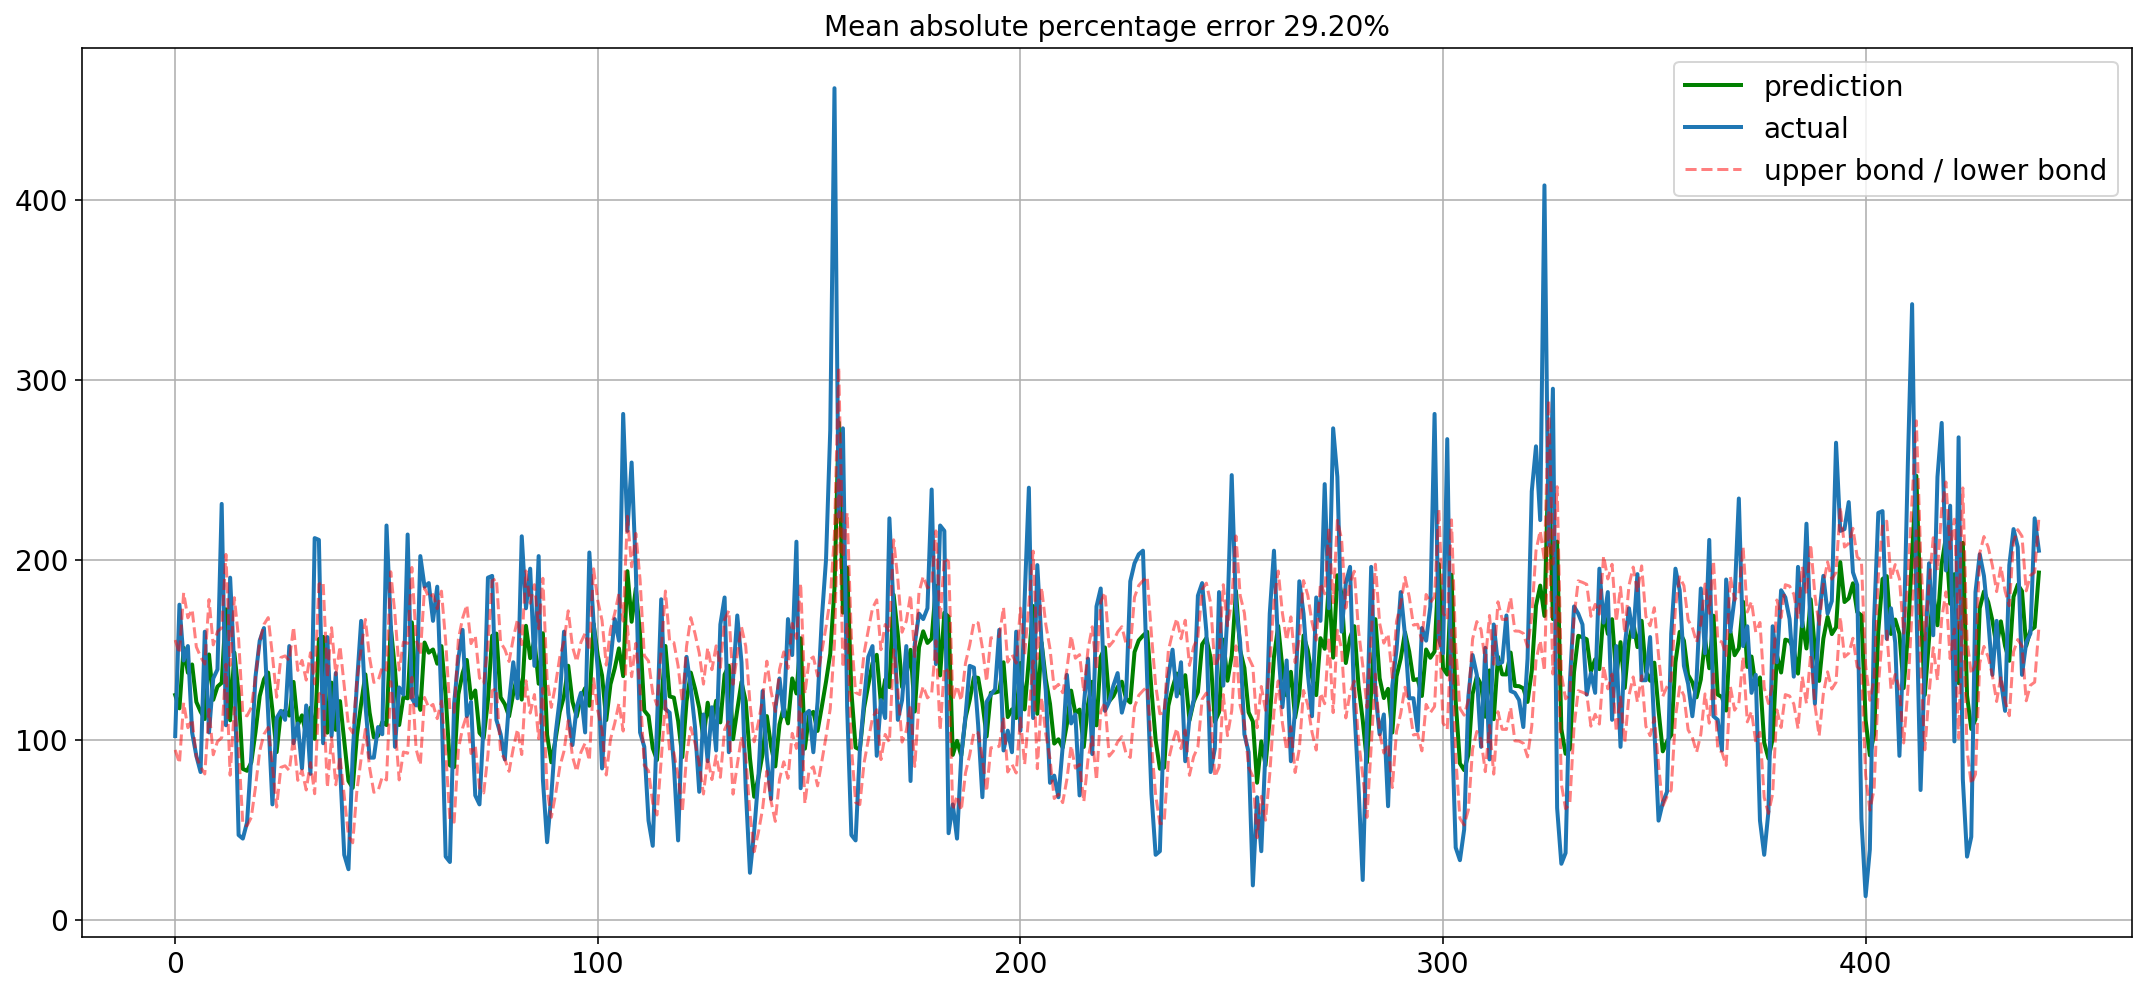

In [63]:
evaluate_model("Линейная регрессия", linear_model, features_train, target_train, features_test, target_test)

RMSE Линейной регресии - 52.65. Модель ошибаеться на 52 заказа в среднем. MAPE - модель ошибается на 33%.

## ElasticNet

In [64]:
%%time
best_model_elastic = None
best_result_elastic = 100
best_alpha = None
best_l1_ratio = None
elastic_alpha = [10, 100, 1000,10000]
elastic_l1_ratio = [0, 0.25, 0.5, 0.75,1]

for alpha_ in elastic_alpha:
    for l1_ratio_ in elastic_l1_ratio:
        model = ElasticNet(random_state=random_state_val,alpha=alpha_, l1_ratio=l1_ratio_)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_result_elastic > rmse:
            best_result_elastic = rmse
            best_model_elastic = model
            best_alpha = alpha_
            best_l1_ratio = l1_ratio_
        
print("Точность лучшей модели ElasticNet на тестовой выборке - RMSE:",best_result_elastic)
print()

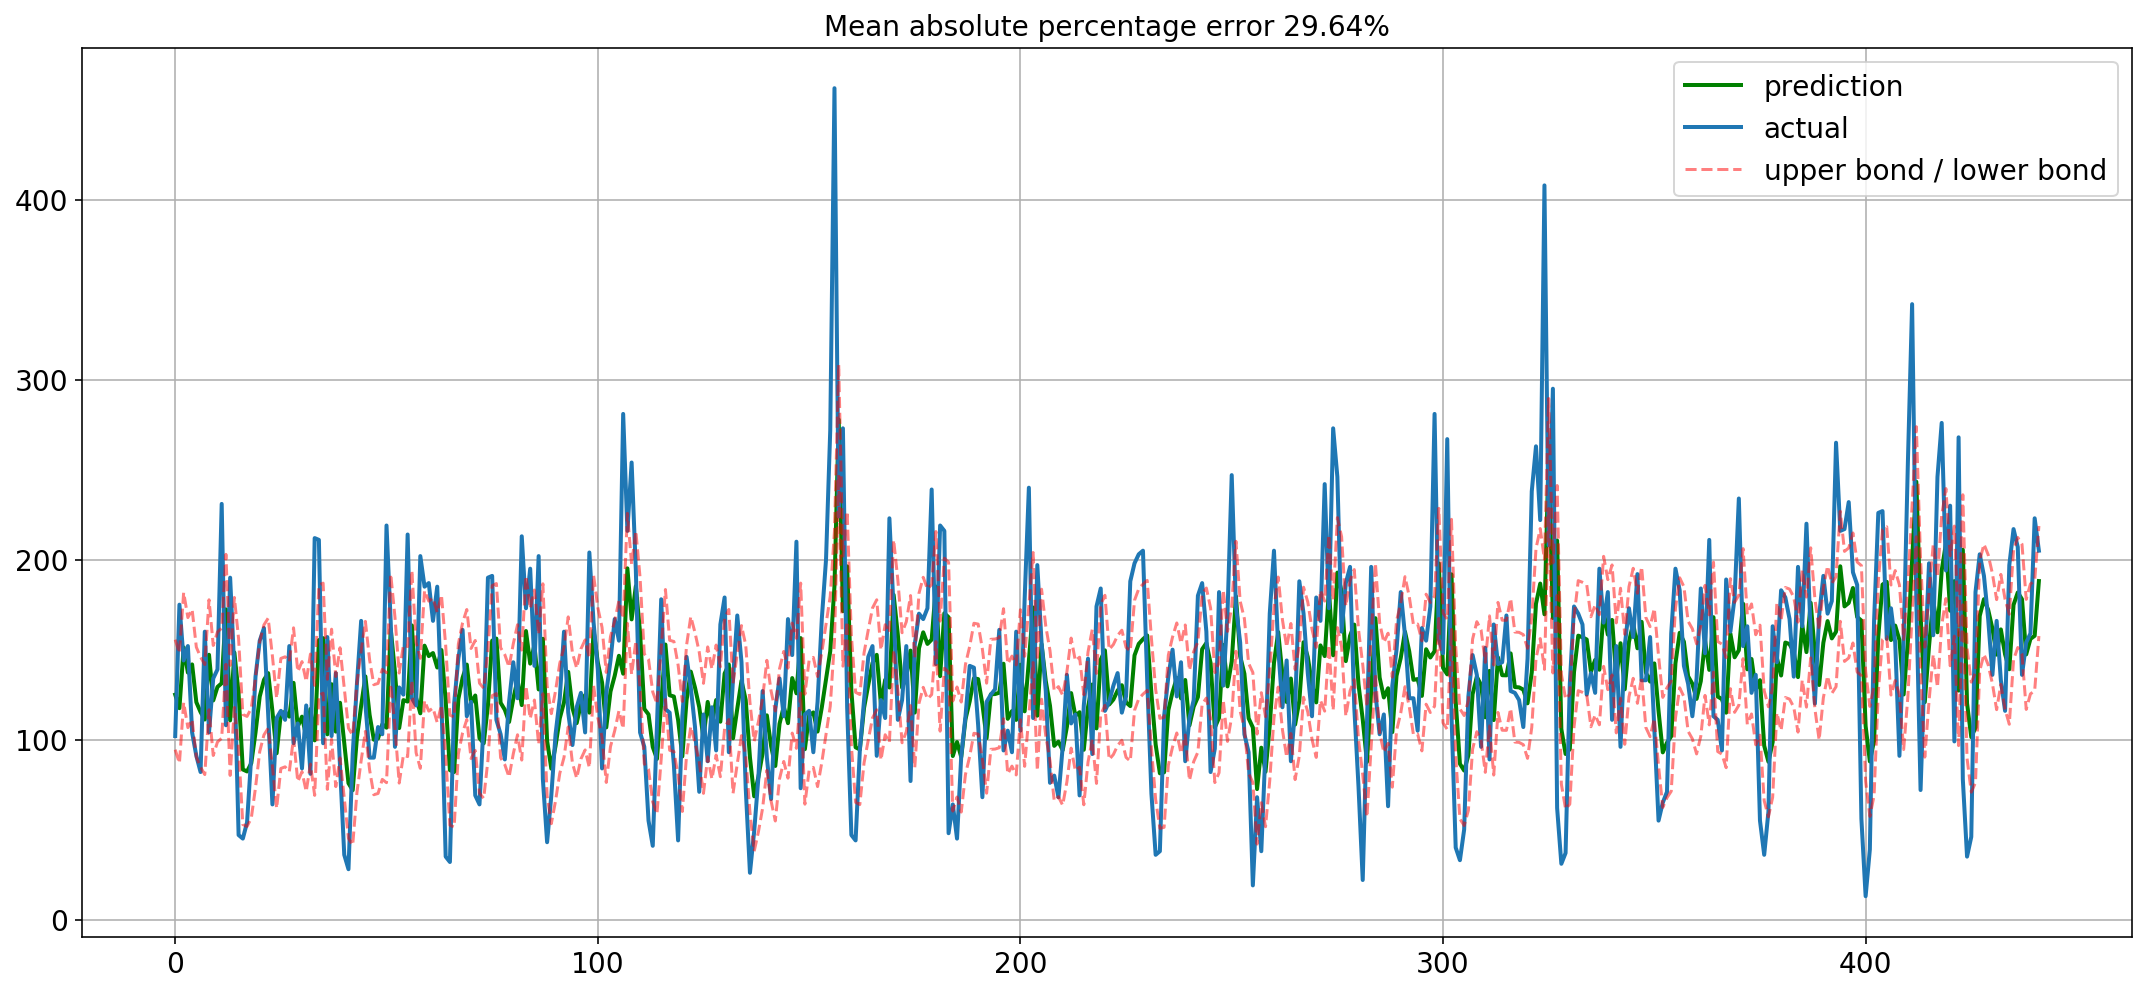

In [65]:
evaluate_model("ElasticNet", best_model_elastic, features_train, target_train, features_test, target_test, {'l1_ratio': best_l1_ratio, 'alpha': best_alpha})

Результаты чуть-чуть хуже по метрике RMSE - 52.75. Модель ошибается на 33%

## Дерево Решений

In [66]:
%%time
# Инициализируем начальный state
best_decision_tree_model = None
best_decision_tree_result = 100
best_decision_tree_depth = 0
best_decision_tree_leaf = 0

# Итерируем гиперпараметр depth от 1 до 10
for depth in range(1,25):
    # итерируем гиперпараметр leaf от 1 до 10
    for leaf in range(1,25):
        # создаем модель, указывая рандомность,критерий ентропийный, глубину дерева, и минимальное количество обьектов в листе. 
        model = DecisionTreeRegressor(random_state=random_state_val, max_depth=depth,min_samples_leaf=leaf)
        # обучение модели
        model.fit(features_train, target_train)
        # предсказание
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_decision_tree_model = model
            best_decision_tree_result = rmse
            best_decision_tree_depth = depth
            best_decision_tree_leaf = leaf

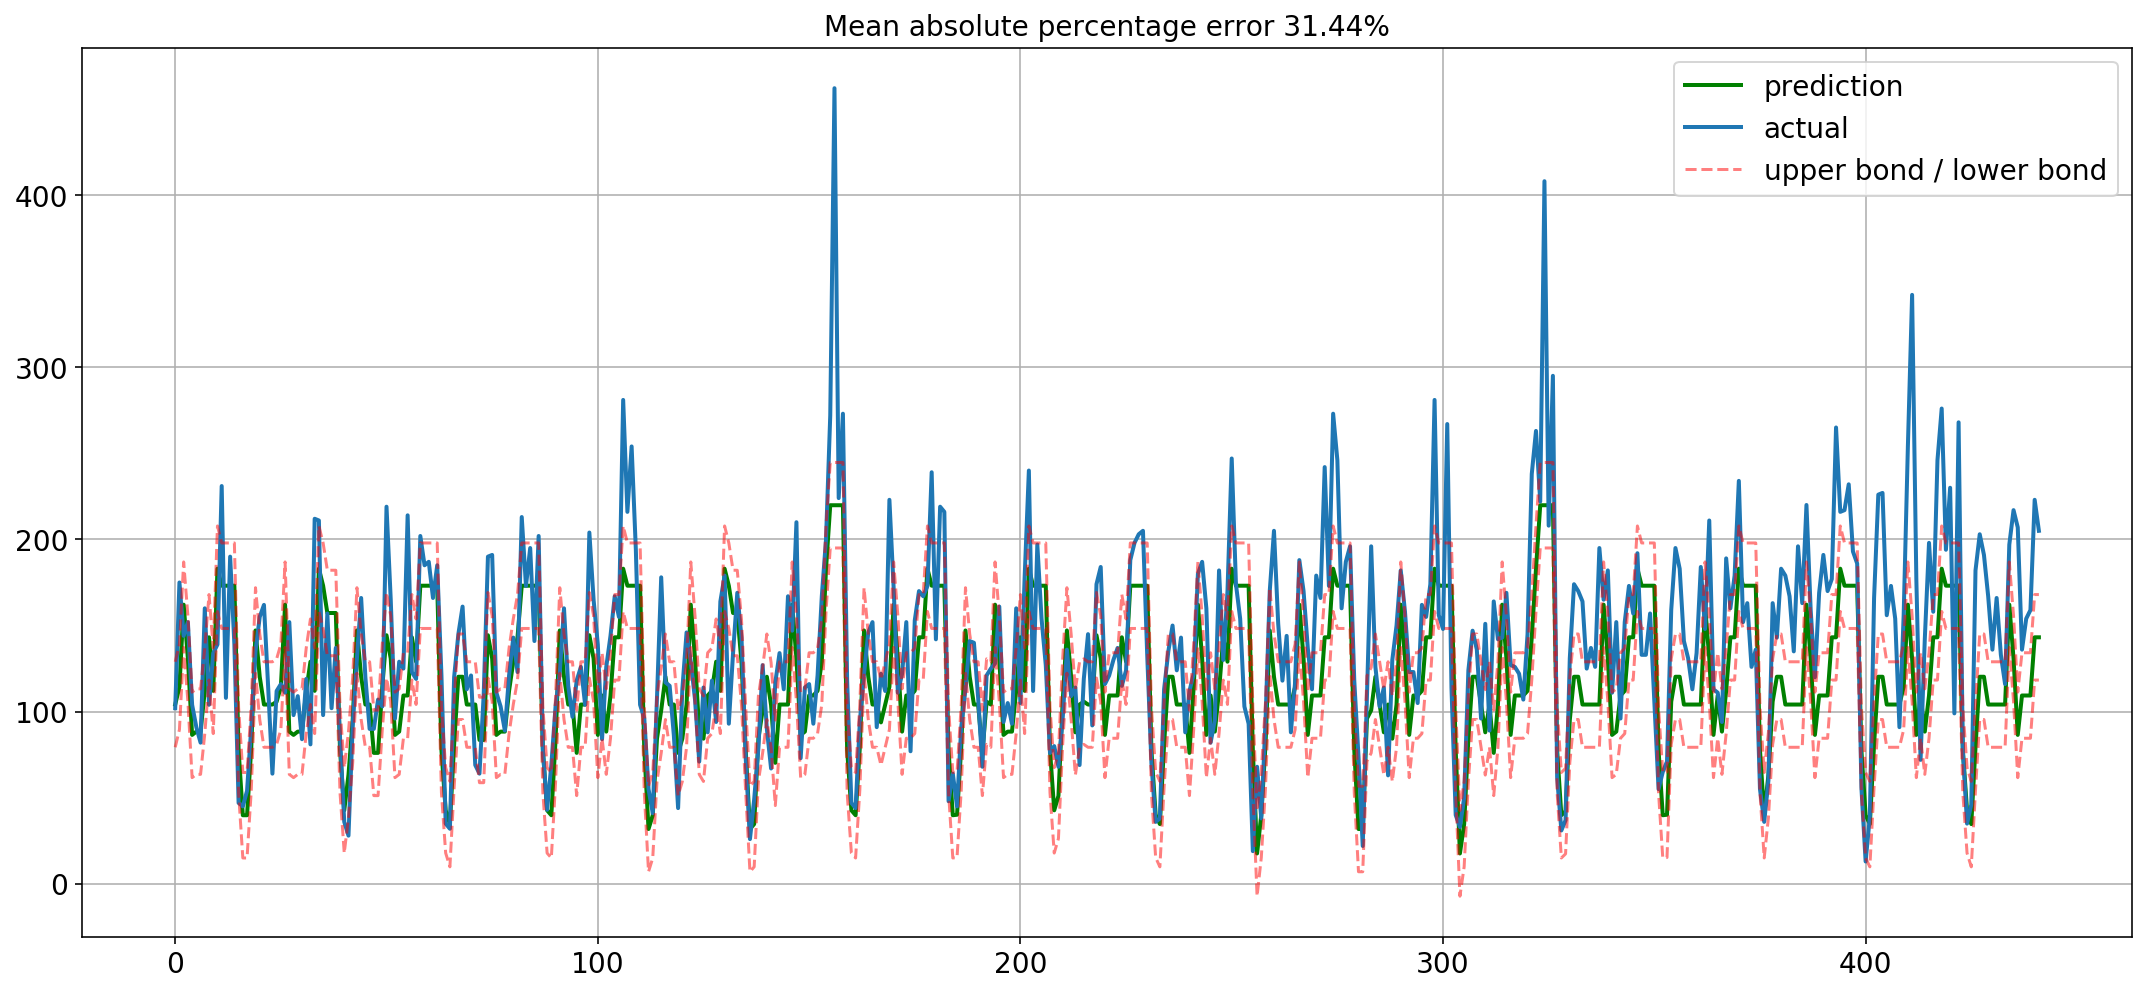

In [67]:
evaluate_model("Decision Tree", best_decision_tree_model, features_train, target_train, features_test, target_test, {'depth': best_decision_tree_depth, 'leaf': best_decision_tree_leaf})

У дерева решений получше результат. Модель ошибается на 46 заказов в среднем, 29%.

## Рандомный лес

In [68]:
%%time
# Инициализируем начальный state
best_randomforest_model = None
best_randomforest_result = 100
best_num_trees = 0
best_randomforest_depth = 0
# Итерируем число деревьев n_estimators от 1 до 10
for est in range(10,61,10):
    # Итерируем гиперпараметр depth от 1 до 10
    for depth in range(1,21):
        # создаем модель, указывая рандомность, глубину дерева, и количество деревьев. 
        model = RandomForestRegressor(random_state=random_state_val, n_estimators=est,max_depth=depth)
        # обучение модели
        model.fit(features_train, target_train)
        # предсказание
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_decision_tree_result > rmse:
            best_randomforest_model = model
            best_randomforest_result = rmse
            best_num_trees = est
            best_randomforest_depth = depth

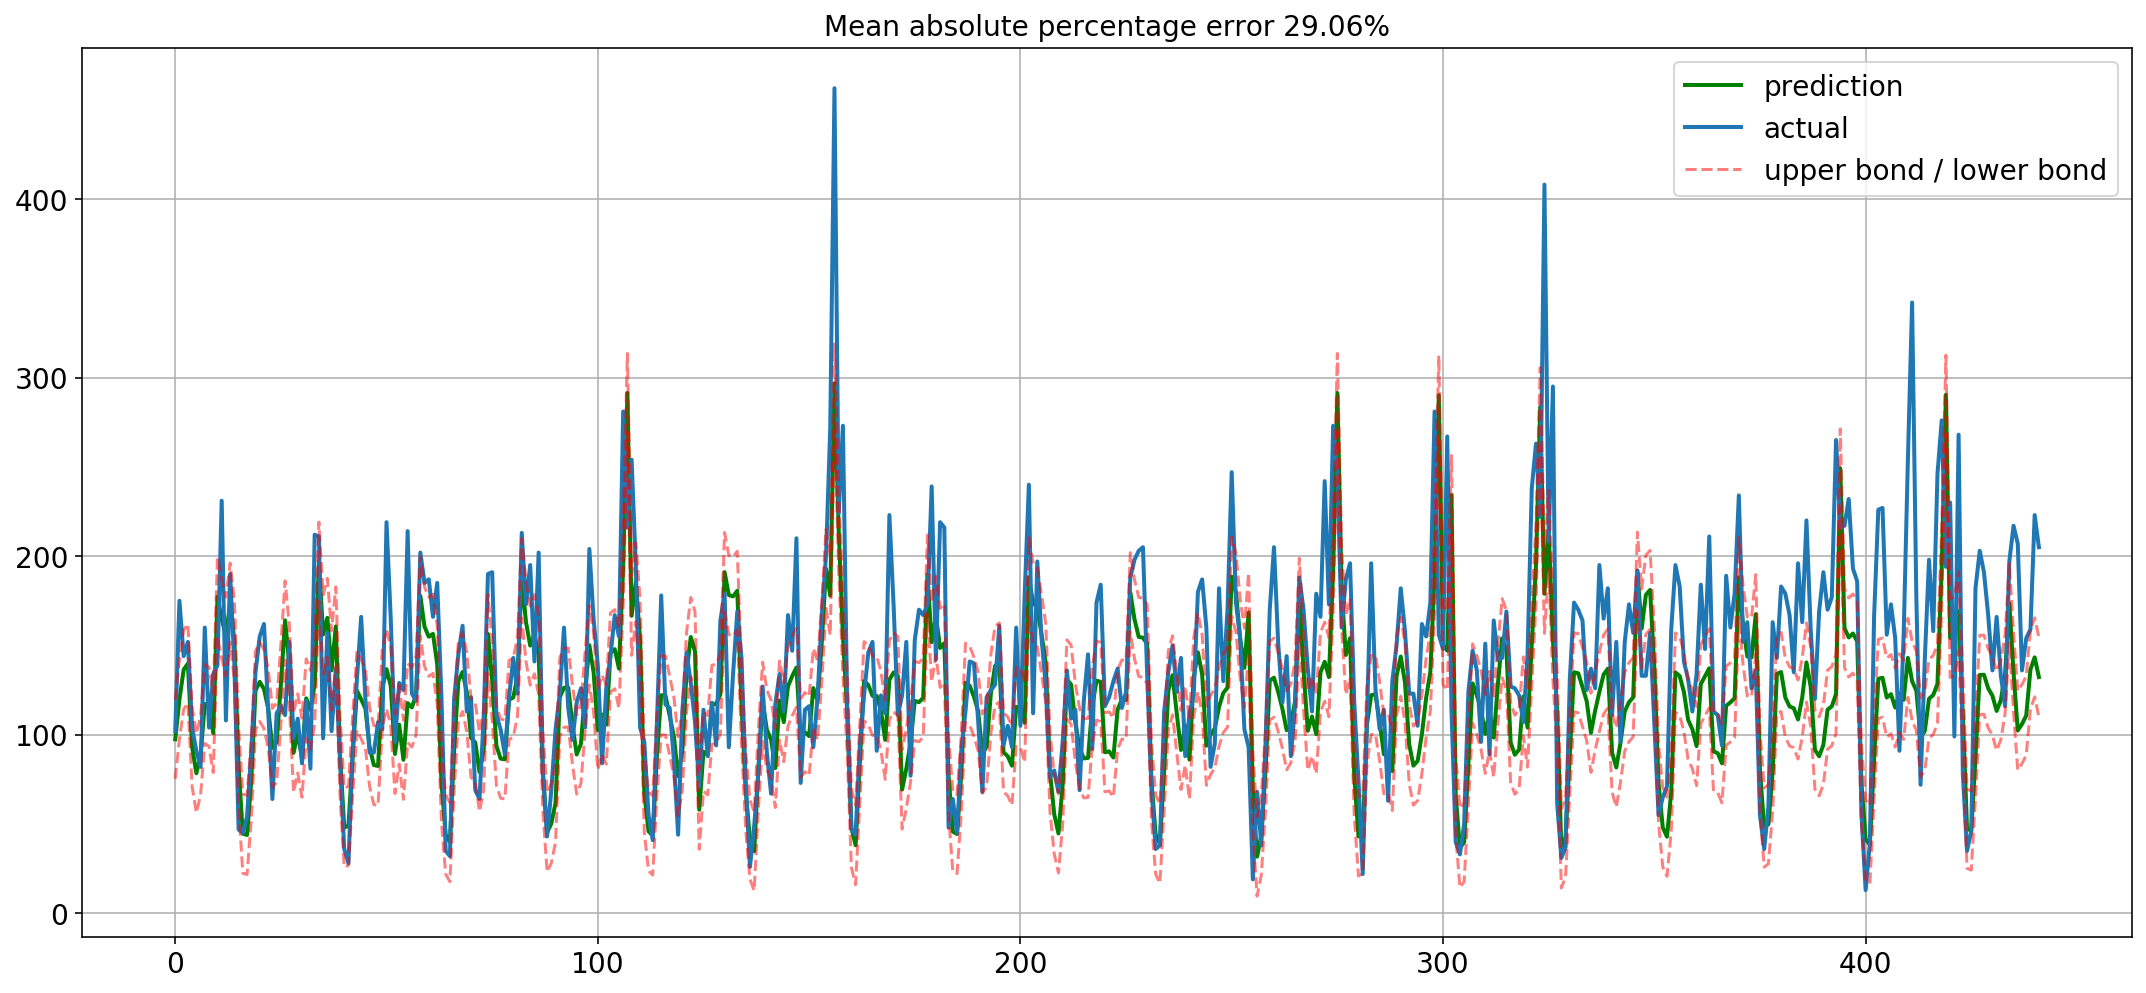

In [69]:
evaluate_model("Random Forest", best_randomforest_model, features_train, target_train, features_test, target_test, {'depth': best_randomforest_depth, 'n_estimators': best_num_trees})

Рандомный лес улучшил показатели по метрикам: 43 - RMSE, 27% - MAPE. Перейдём к бустингам.

## XGBoost

In [70]:
%%time
# Инициализируем начальный state
best_xgboost_model = None
best_xgboost_result = 100
best_xgboost_depth = 0
best_xgboost_estimators = 0
for depth in range(3,20,2):
    for estimators in range(1,24,2):
        model = xgb.XGBRegressor(n_jobs=-1,n_estimators=estimators,max_depth=depth) 
        # обучение модели
        model.fit(features_train, target_train)
        # предсказание
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_xgboost_result > rmse:
            best_xgboost_model = model
            best_xgboost_result = rmse
            best_xgboost_depth = depth
            best_xgboost_estimators = estimators

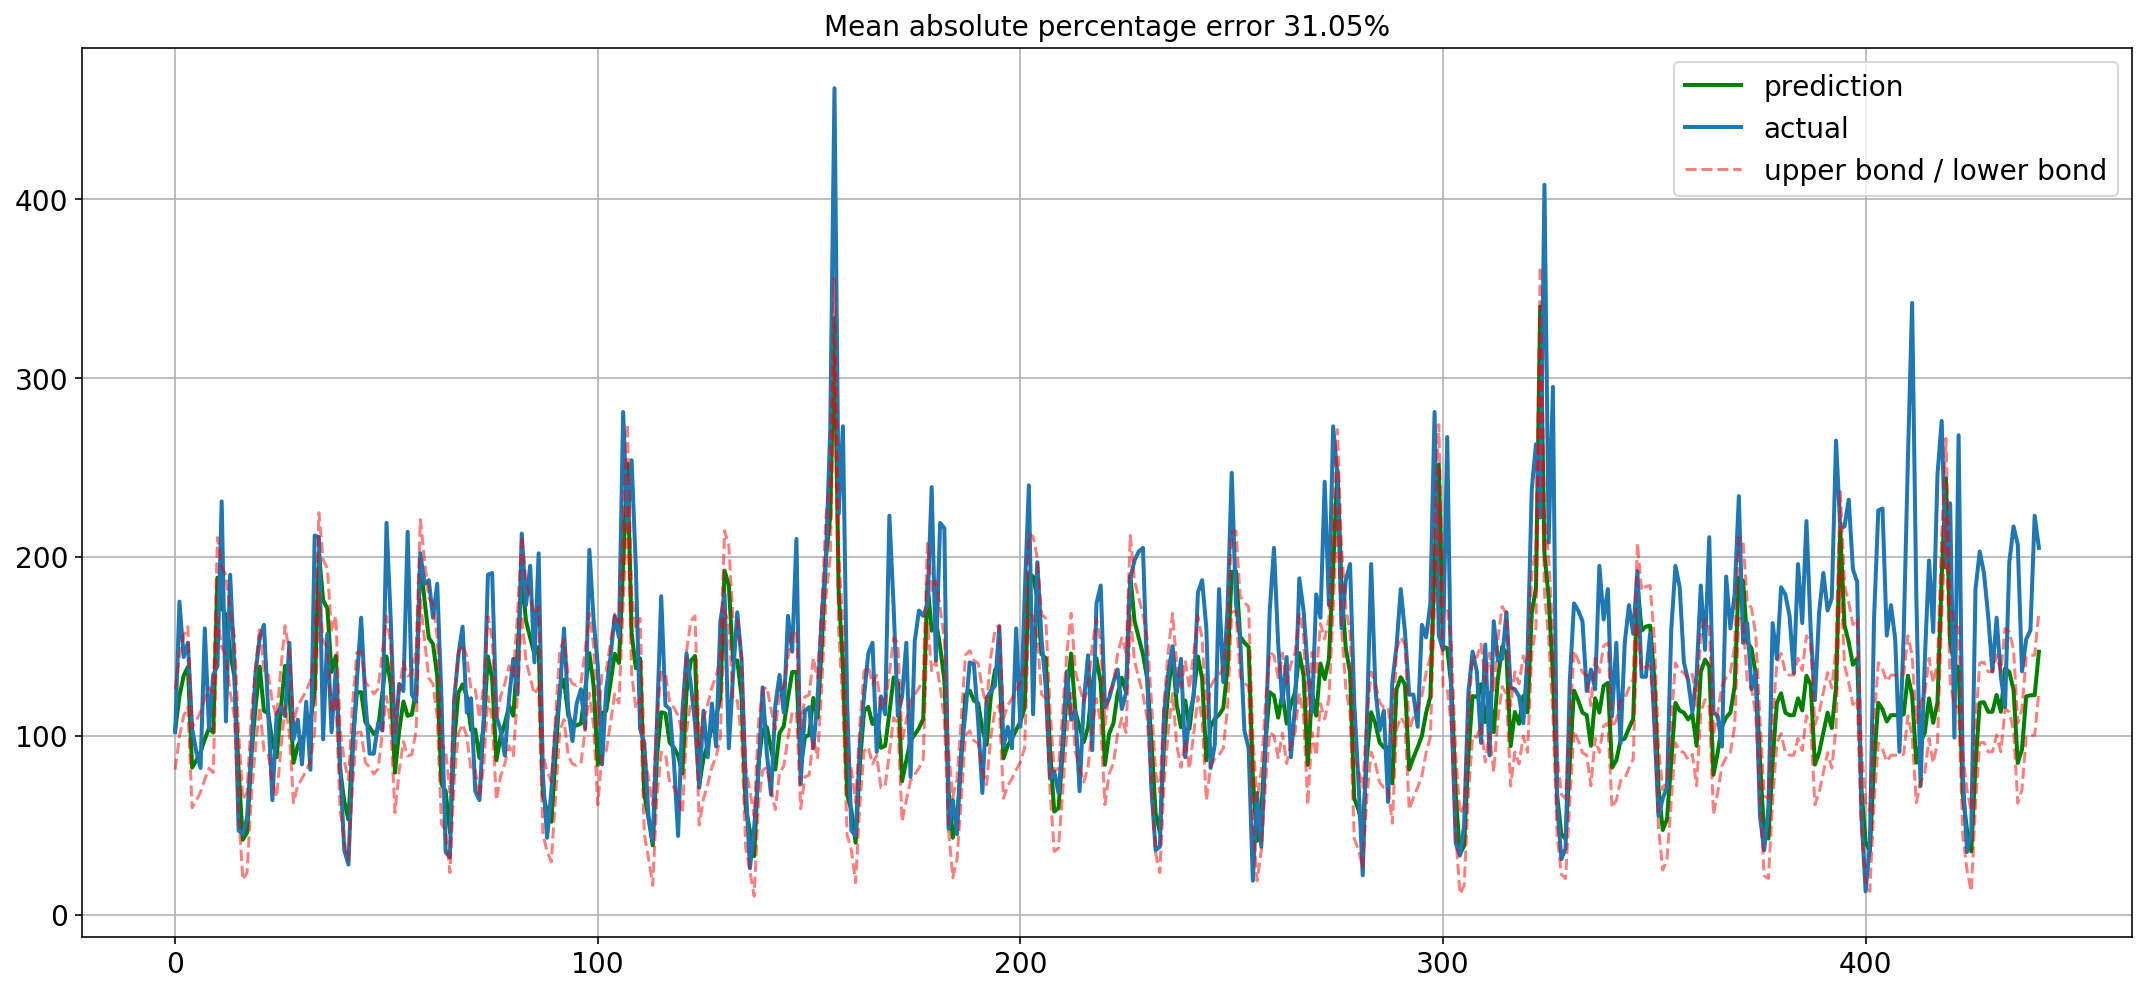

In [71]:
evaluate_model("XGBoost", best_xgboost_model, features_train, target_train, features_test, target_test, {'depth': best_xgboost_depth, 'n_estimators': best_xgboost_estimators})

XGBoost показал результаты чуть-чуть хуже, чем Рандомный лес. RMSE - 44.93. MAPE - 28%.

## LightGBM

In [72]:
%%time
# Инициализируем начальный state
best_lightgbm_model = None
best_lightgbm_result = 100
best_lightgbm_objective = ''
best_lightgbm_boosting_type = ''
best_lightgbm_num_leaves = 0
best_lightgbm_max_depth = 0
for depth in [15,20,25,30,50]:
    for leaves in [10,100,200,300]:
        for objective in ['regression','binary']:
            for boosting_type in ['dart', 'gbdt','goss']:
                model = lgb.LGBMRegressor(n_jobs=-1,boosting_type=boosting_type, num_leaves=leaves, max_depth=depth, objective=objective)
                # обучение модели
                model.fit(features_train, target_train)
                # предсказание
                predicted_test = model.predict(features_test)
                mse = mean_squared_error(target_test, predicted_test)
                rmse = mse ** 0.5
                if best_lightgbm_result > rmse:
                    best_lightgbm_model = model
                    best_lightgbm_result = rmse
                    best_lightgbm_objective = objective
                    best_lightgbm_boosting_type = boosting_type
                    best_lightgbm_num_leaves = leaves
                    best_lightgbm_max_depth = depth

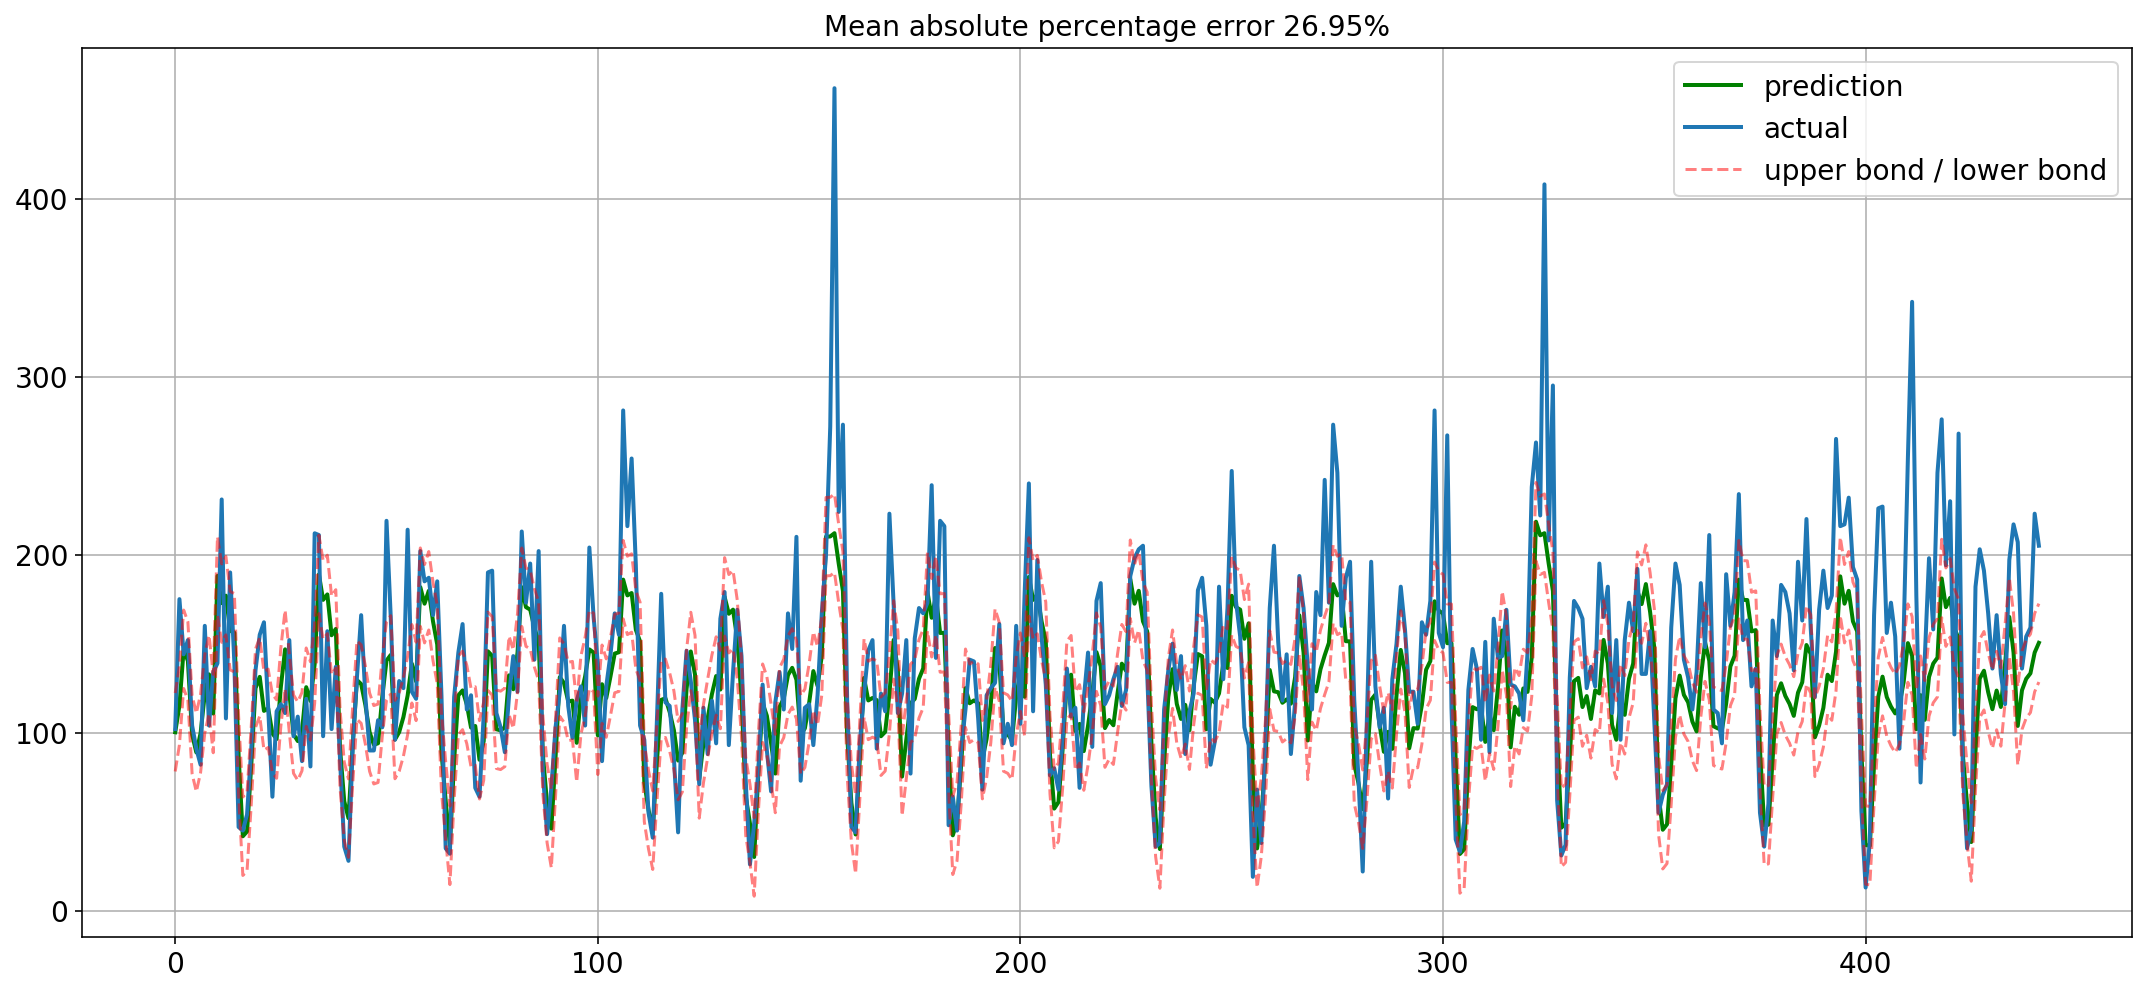

In [73]:
evaluate_model("LightGBM", best_lightgbm_model, features_train, target_train, features_test, target_test, {'depth': best_lightgbm_max_depth,
                                                                                                           'num_leaves': best_lightgbm_num_leaves,
                                                                                                            'objective': best_lightgbm_objective,
                                                                                                            'boosting_type': best_lightgbm_boosting_type})

Модель показала хорошие результаты на метриках. Ошибаетс на 42 заказа в среднем - RMSE. 26% - MAPE.

## CatBoost

In [74]:
%%time
# Инициализируем начальный state
best_catboost_model = None
best_catboost_result = 100
best_catboost_l2_leaf_reg = 0
best_catboost_max_depth = 0
for depth in [5,10]:
    for l2_reg in [1,2,3]:
        model = CatBoostRegressor(loss_function='RMSE',random_state=random_state_val,silent=True,l2_leaf_reg=l2_reg, depth=depth)
        # обучение модели
        model.fit(features_train, target_train)
        # предсказание
        predicted_test = model.predict(features_test)
        mse = mean_squared_error(target_test, predicted_test)
        rmse = mse ** 0.5
        if best_catboost_result > rmse:
            best_catboost_model = model
            best_catboost_result = rmse
            best_catboost_l2_leaf_reg = l2_reg
            best_catboost_max_depth = depth

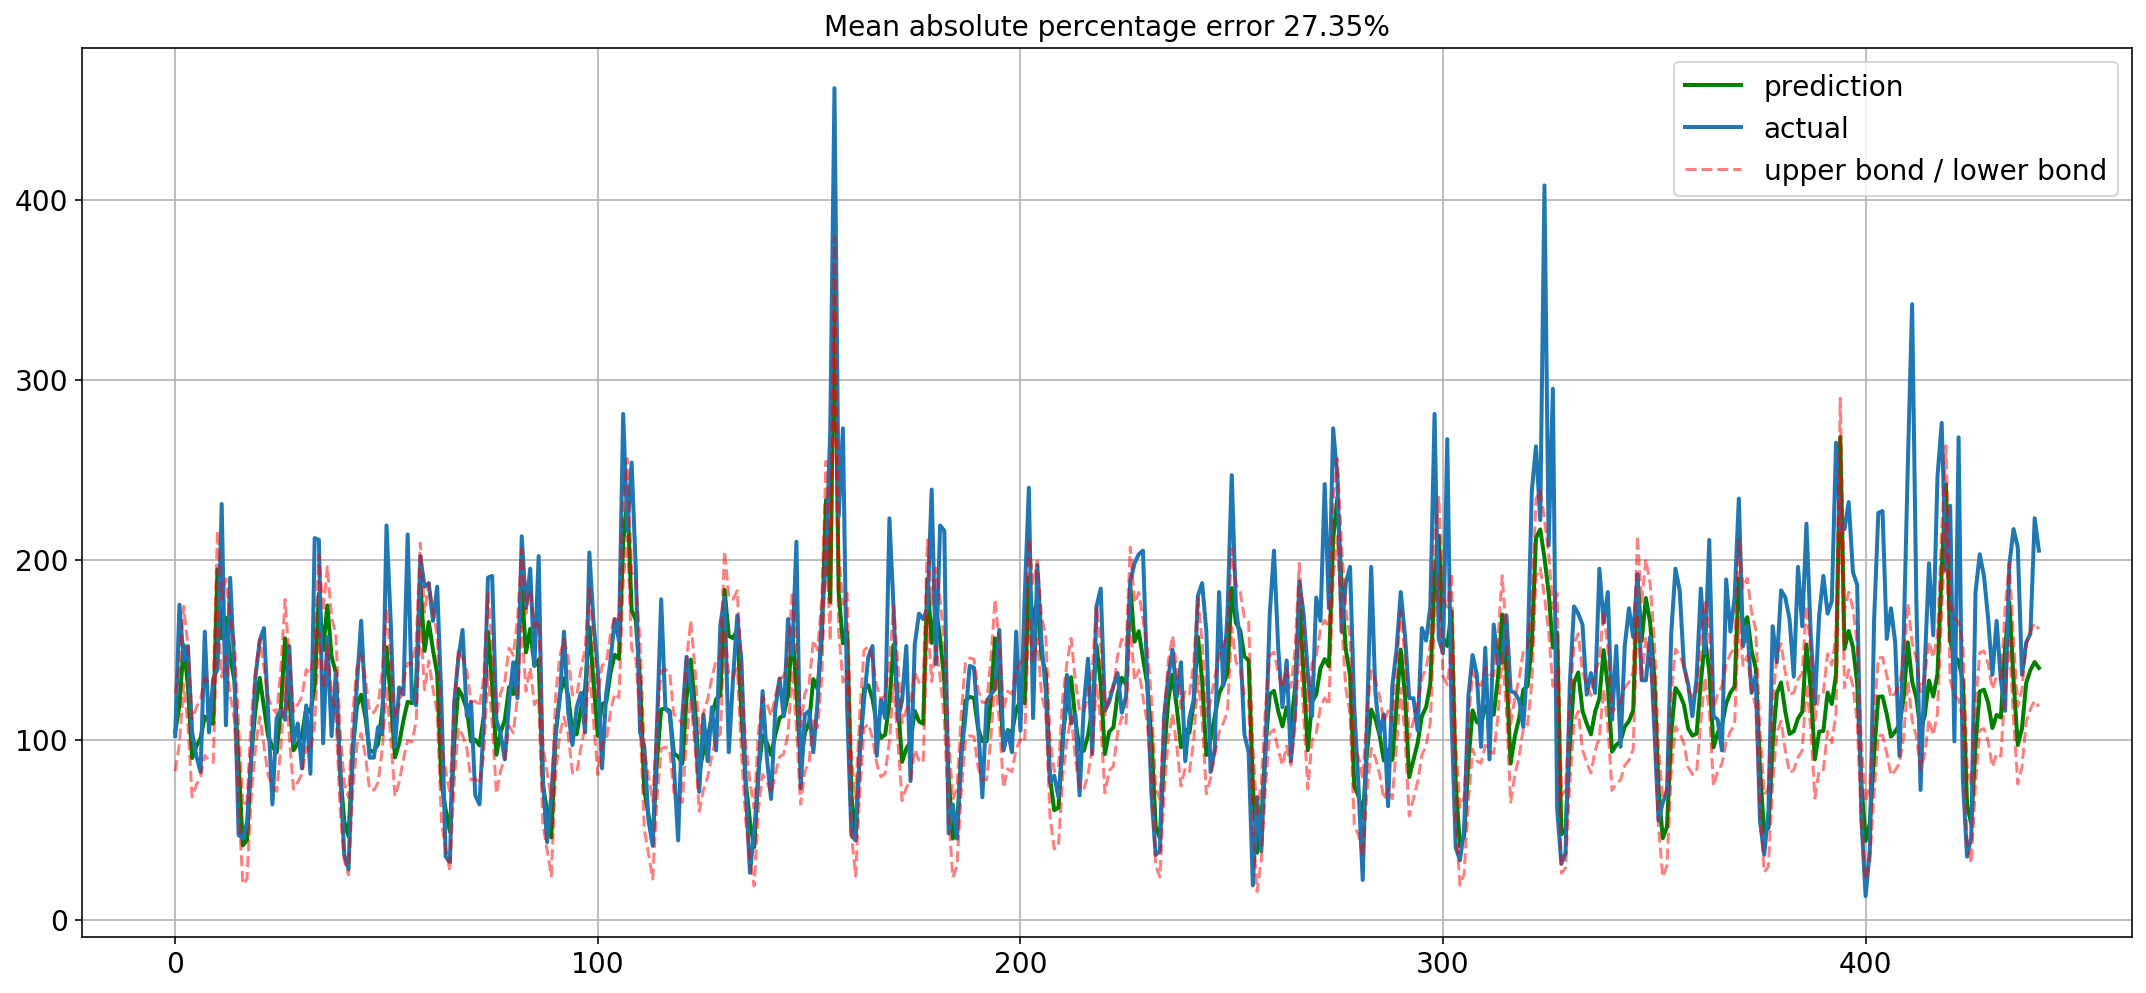

In [75]:
evaluate_model("CatBoost", best_catboost_model, features_train, target_train, features_test, target_test, {'depth': best_catboost_max_depth,
                                                                                                           'l2_leaf_reg': best_catboost_l2_leaf_reg})

У CatBoost тоже хорошие результаты. RMSE - 43.10, MAPE - 27%.

## Dummy

In [76]:
# создаем модель
dummy_model = DummyRegressor(strategy="constant", constant=target_train.median())
# тренируем модель
dummy_model.fit(features_train,target_train)

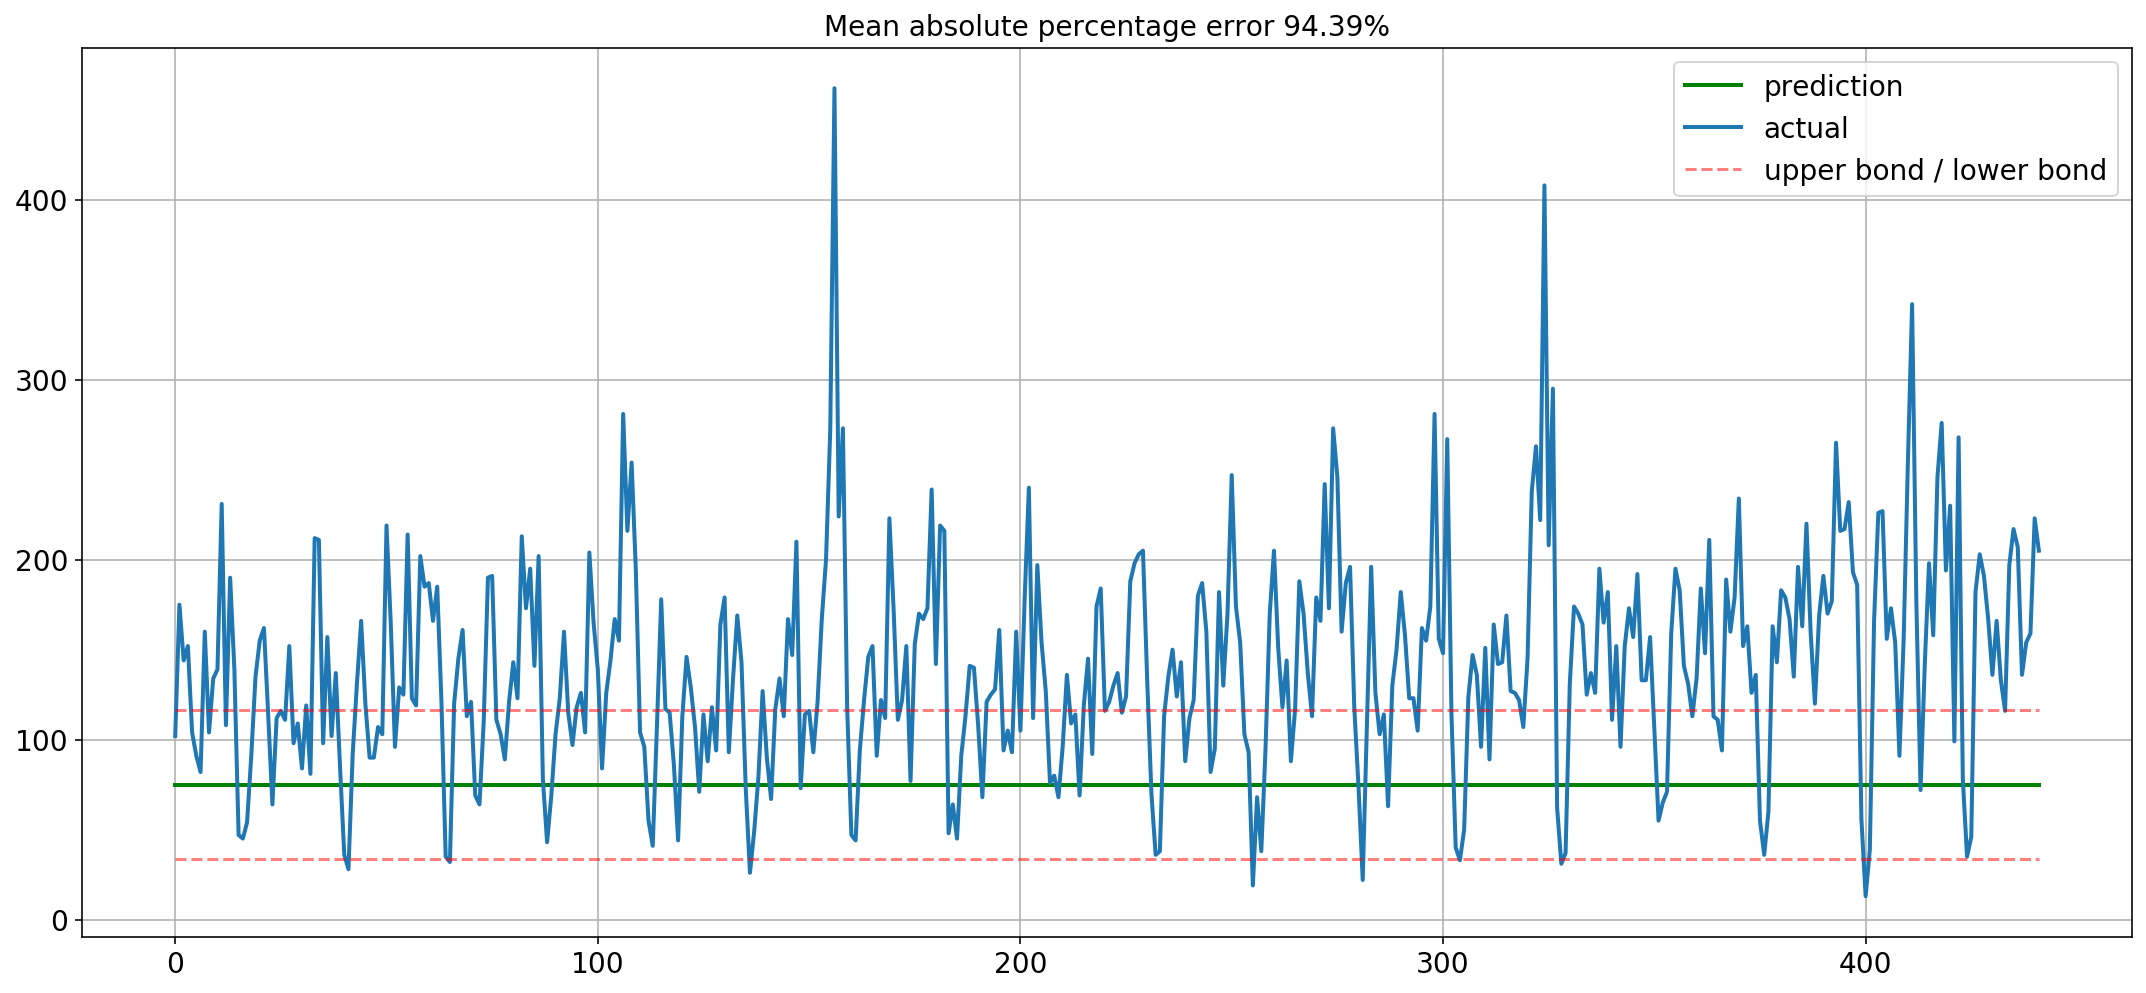

In [77]:
evaluate_model('Дамми модель', dummy_model, features_train, target_train, features_test, target_test)

## Предыдущее значение ряда

In [78]:
pred_previous = target_test.shift()

In [79]:
pred_previous.iloc[0] = target_train.iloc[-1]

In [80]:
mse_previous = mean_squared_error(target_test, pred_previous)
mape_previous = mean_absolute_percentage_error(mse_previous, target_test)
rmse_previous = mse_previous ** 0.5
print(f'RMSE предыдущее значение на тестовой выборке: {rmse_previous}')
print(f'MAPE предыдущее значение на тестовой выборке: {mape_previous}')

In [81]:
ml_models_stats['previous'] = {
    'название': 'previous',
    'rmse_train':None,
    'rmse_test':rmse_previous,
    'mape_train':None,
    'mape_test':mape_previous
}

## Вывод

Мы исследовали модели машинного обучения. Перейдём к результатам. 

<a id="resultsRearchModel"></a>
# Этап 6 Результаты исследования моделей машинного обучения

На этом этапе надо проанализировать качество моделей.

Мы проверили исследование 7 моделей машинного обучения (*Linear Regression*,*ElasticNet* *Decision Tree*, *Random Forest*, *XGBoost*, *LightGBM*, *CatBoost*).

Для бизнеса важна метрика RMSE. RMSE должно быть не 48.

Напишем дополнительную функцию для вывода графиков

In [82]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Создадим таблицу из полученных данных.

In [83]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

Модели которые прошли проверку на вменяемость.

In [84]:
approved_models = ml_models.query("rmse_test < 87")
approved_models

Все модели прошли проверку на вменяемость.

Отфильтруем те модели, чьи показатели метрики RMSE не соответствуют требованию бизнеса. RMSE < 48

In [85]:
business_approved_models = approved_models.query("rmse_test < 48")
business_approved_models

Проверку прошли: Decision Tree, Random Forest, XGBoost, LightGBM, CatBoost

Найдём самую лучшую модель по метрике RMSE на тестовой выборке

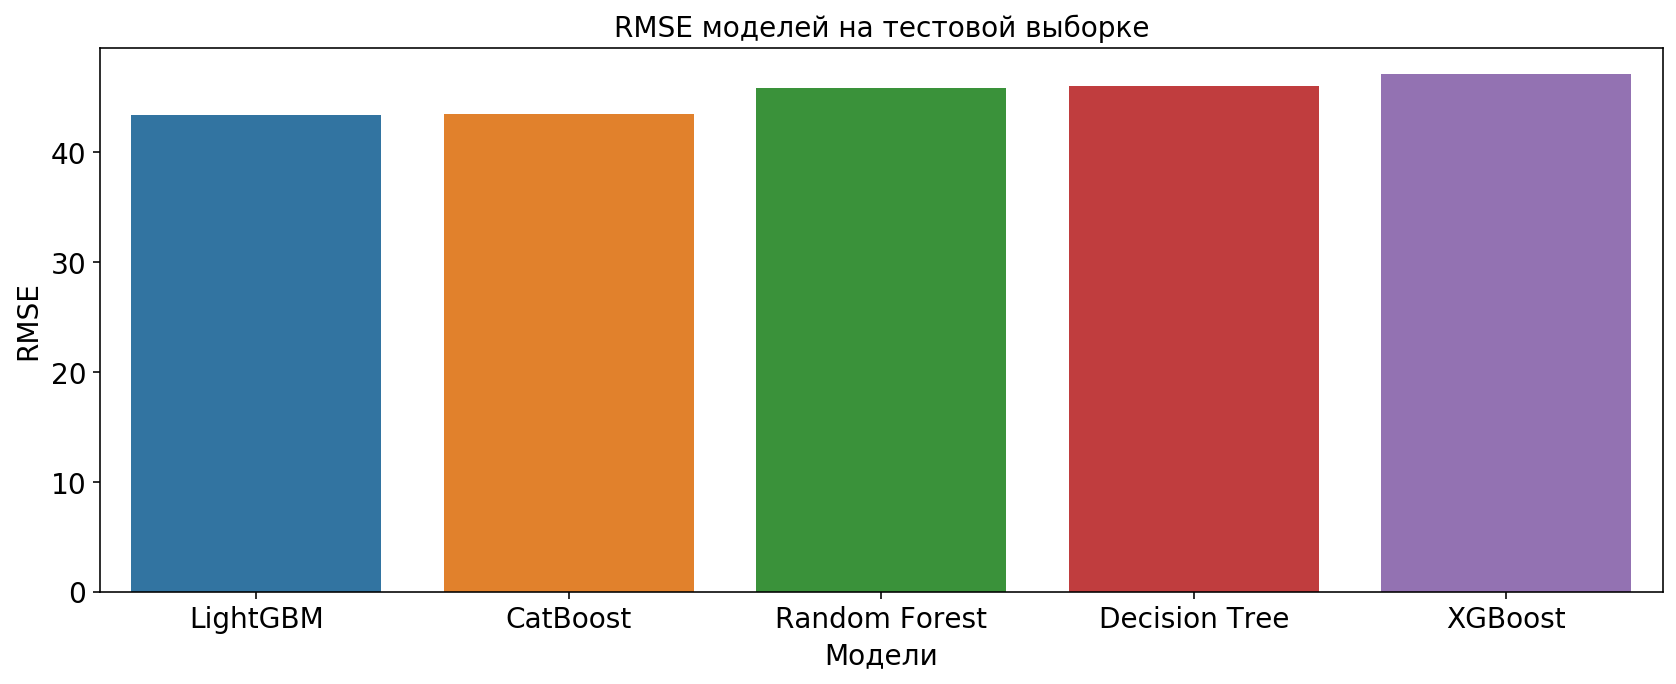

In [86]:
rmse_test_sorted = business_approved_models.sort_values(by='rmse_test',ascending=True).reset_index()
display(rmse_test_sorted[['название','rmse_test']])
# Рисуем график
drawPlot(rmse_test_sorted, 'название','rmse_test','Модели','RMSE','RMSE моделей на тестовой выборке','название' )

Самый хороший показатель выдала модель LightGBM - 42.623. Следом идет CatBoost - 43.109 

Найдём лучшую модель по метрике MAPE

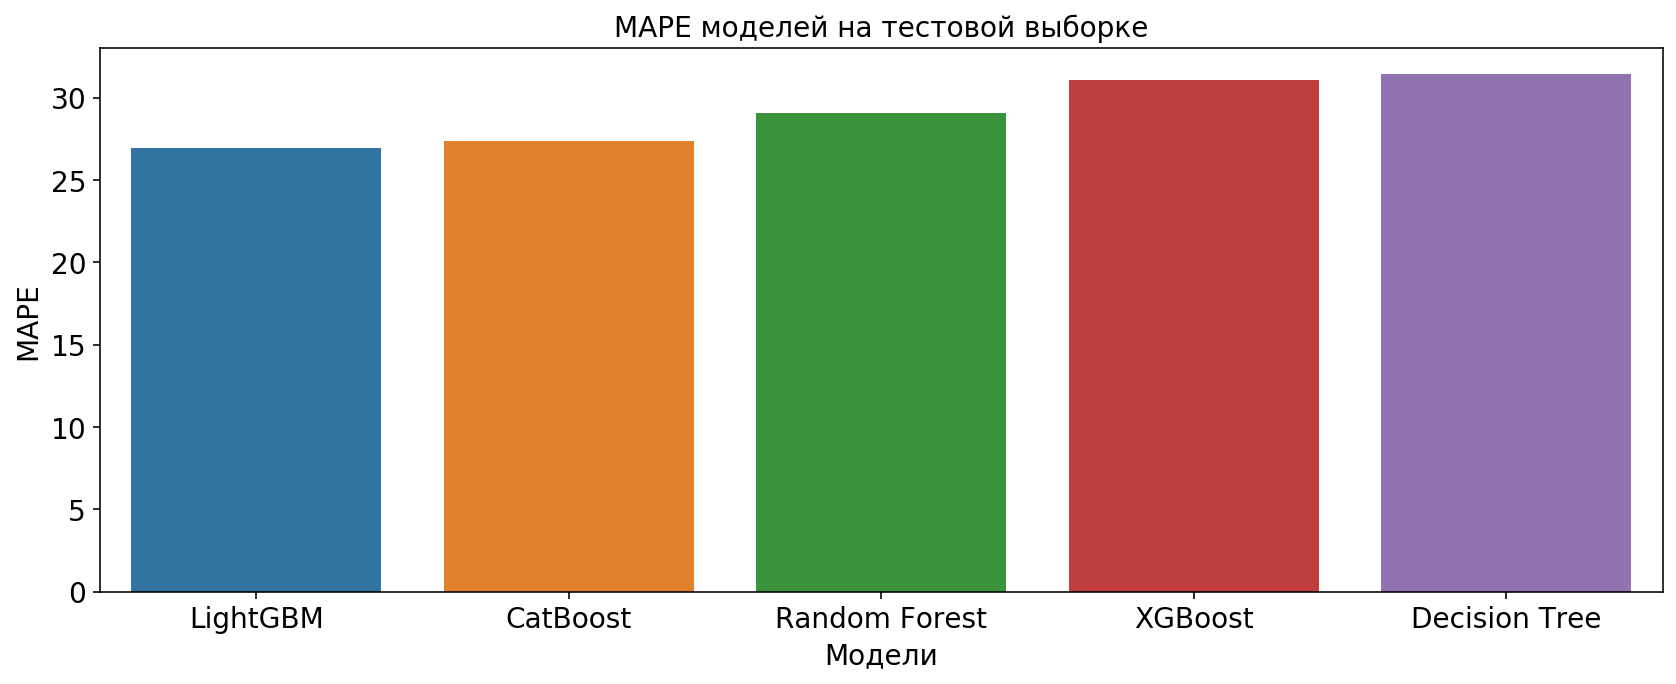

In [87]:
mape_test_sorted = business_approved_models.sort_values(by='mape_test',ascending=True).reset_index()
display(mape_test_sorted[['название','mape_test']])
# Рисуем график
drawPlot(mape_test_sorted, 'название','mape_test','Модели','MAPE','MAPE моделей на тестовой выборке','название' )

Хороший показатель MAPE у LightGBM - 26%. На втором месте - Random Forest - 27%

Основываясь на полученных результатах и графиках, выберем лучшую модель - **LightGBM**. У модели хороший показатель точности на двух метриках RMSE, MAPE.

<a id="results"></a>
# Этап 7 - Результаты работы

В ходе проекта мы успешно построили модели Машинного Обучения для предсказывания количества заказов такси на следующий час.  Выбрали лучшую модель, которая соотвествует требованию бизнеса. В проекте мы сделали:
1. Предобработка данных:
    - Сделали ресемплирование данных по одному часу. 
    - Данные прошли финальную проверку.
2. Анализ данных:
    - Аномальных значений не обнаружилось. 
    - Скользящее среднее:
        - В первом месяце скользящее среднее изменялось в диапазоне от 45 до 75 заказов в день
        - В первой неделе Марта, можем увидеть преобладающее количество заказов в субботу и понедельник.
        - Суббота: большинство заказов было в полночь. Также, количество заказов возрастает утром в 9:00 утра, 15:00 дня, 20:00 вечера.
        - Понедельник: всплеск заказов в полночь. Получается такси больше используют ночью ?? Количество заказов возрастает в 12:00 дня, 18:00 вечера.
        - Последняя неделя Марта, большое количество заказов приходиться на понедельник. 
        - Понедельник: Количество заказов возрастает в 10:00-11:00 утра, 15:00-16:00 дня, и 22:00-23:00 вечера.
        - Мы обнаружили тренд - люди часто заказывают такси ночью. 
        - В последнем месяце, диапазон у скользящего среднего увеличился от 100 до 200 заказов в день.
        - Первая неделя последнего месяца: всплеск заказов в субботу и в понедельник.
        - Суббота: количество заказов возрастает вечером. 
        - Количество заказов возрастает вечером и в понедельник.
        - Последняя неделя: большое количество заказов приходится на понедельник.
        - Понедельник: люди используют такси утром 09:00-10:00 часов, в обед (14:00-15:00), и вечером 22:00-23:00

    - Посмотрев данные за первый и последний месяц, у меня появилась гипотеза: такси часто используют вечером и ночью, также по дням: в понедельник и субботу.

    - Тренд:
        - идет ежемесячное увеличение количество заказов такси.

    - Сезонность:
        - Количество заказов падает по понедельникам и средам...
3. Feature Engineering:
    - Мы добавили признаки: 
        1. Календарные 
        2. Отстающие значения
        3. Скользящее среднее
    - Также, разделили общую выборку на 2 части в соотношении (*90/10*): обучающую, тестовую. Отделили целевой признак.
4. Исследование моделей: 
    - Мы проверили исследование 7 моделей машинного обучения (*Linear Regression*,*ElasticNet* *Decision Tree*, *Random Forest*, *XGBoost*, *LightGBM*, *CatBoost*).
    - RMSE: Самый хороший показатель выдала модель LightGBM - 42.623.
    - MAPE: Хороший показатель MAPE у LightGBM - 26%.
    
Основываясь на полученных результатах и графиках, выберем лучшую модель - **LightGBM**. У модели хороший показатель точности на двух метриках RMSE, MAPE.